# Modélisation numérique du trafic routier : Domaines paramétriques d'émergence des embouteillages

## Introduction<a id='intro_id'></a>
Sur la route, le souhait commun est d'effectuer son trajet le plus rapidement possible. La plupart du temps en respectant le code de la route et sans collisions. Pourtant, il n'est pas rare d'observer un phénomène d'embouteillage alors même qu'il semble n'y avoir aucun obstacle ou raison de ralentir. Cela va à l'encontre de ce souhait global de se déplacer rapidement. Pour comprendre l'émergence de ce phénomène, nous proposons de modéliser une portion de route du point de vue de chaque automobiliste.

Notre hypothèse initiale considère que ce phénomène sub-optimal global provient d'une recherche d'optimisation individuelle. C.F. : [Comment se forment les embouteillages ?](#doc_1stApproach_id) C'est un effet bien connu en théorie des jeux, et nous cherchons à savoir quels paramètres du comportement des usagers mènent à ce phénomène d'embouteillage. Une hypothèse annexe propose que pour un même comportement des usagers, les paramètres de circulation (comme la vitesse maximale et la densité) peuvent faire émerger ou non des embouteillages.

La circulation routière est un phénomène physique assez complet et déterministe étant donné l'input du conducteur. Notre modélisation est constituée de 2 parties :
- La modélisation de l'action du conducteur
- La modélisation de la cinématique de la voiture

La modélisation du conducteur se base sur l'environnement de la voiture. Le conducteur capte certaines informations et réagit en fonction. Soit par une accélération positive (accélérateur), soit par une accélération négative (frein), soit par une accélération nulle. Ces accélérations sont conditionnées par les capacités de la voiture et par la réaction minimum de l'automobiliste.

Nous présentons dans un premier temps plusieurs modélisations numériques d'un conducteur. Cela permet de comparer les profils de vitesse des différents modèles et nous a permis de choisir le plus adapté à l'analyse finale de l'impact des paramètres. Pour valider l'espace de paramètres de notre simulation, nous conduisons une expérience avec mesure d'accélération. Enfin, avec le bon algorithme de modélisation et l'espace de paramètres possible, nous cherchons à séparer l'espace en 2 zones distinctes. Une zone où une petite perturbation n'induit pas d'embouteillage (la perturbation est amortie) et une zone où la perturbation s'amplifie et se propage parmi les voitures. Le résultat de cette séparation nous permettra ainsi de répondre à la question initiale sur l'impact des paramètres comportementaux du conducteur.

Pour les besoins de la partie informatique de ce travail, nous nous sommes servi des modules suivants :

In [1]:
import numpy as np                      # Traitement de tableau de valeurs
import matplotlib.pyplot as plt         # Affichage des diagrames
import pandas as pd                     # Lecture du CSV et stockage des mesures
from scipy.optimize import curve_fit    # Ajustement des paramètres du modèle


## Index<a id='index_id'></a>
- [Introduction](#intro_id)
- [Index](#index_id)
- [Conduite de projet](#gdp_id)
- [Mise en place de l'espace de travail](#workspace_id)
- [Recherche documentaire](#doc_id)
- [1) Modèle d'accélération variable](#varA_id)
    - [Présentation](#varA_pres_id)
    - [Modèle et équations](#varA_equations_id)
    - [Modélisation numérique](#varA_modnum_id)
- [2) Modèle macroscopique fluide](#fluid_id)
    - [Présentation](#fluid_pres_id)
    - [Modèle et équations](#fluid_equations_id)
    - [Modélisation numérique](#fluid_modnum_id)
- [3) Modèle discret de la route](#road_id)
    - [Présentation](#road_pres_id)
    - [Modèle et équations](#road_equations_id)
    - [Modélisation numérique](#road_modnum_id)
- [4) Modèle d'accélération constante](#constA_id)
    - [Présentation](#constA_pres_id)
    - [Modèle et équations](#constA_equations_id)
    - [Modélisation numérique](#constA_modnum_id)
- [5) Comparaison des modèles aux mesures expérimentales](#exp_id)
    - [Protocole expérimental](#exp_protocol_id)
    - [Lecture des mesures](#exp_datareading_id)
    - [Transformation des mesures et extraction de la constante g](#exp_transform_id)
    - [Validation des données par mesures GPS](#exp_gps_id)
    - [Fit aux modèles](#exp_fit_id)
    - [Comparaison des fit et extraction des paramètres](#exp_fitAnalysis_id)
- [6) Etude d'émergence d'embouteillage](#traficEmergence_id)
    - [Etude de l'impact des paramètres de la route](#traficEmergence_roadParametters_id)
    - [Etude de l'impact des paramètres du comportement de l'automobiliste](#traficEmergence_driverParametters_id)
- [Limites des modèles présentés et prudence sur l'interprétation des résultats](#limits_id)
- [Conclusion](#conclusion_id)
- [Conseils pour l'aprofondissement du travail présenté](#advices_id)



## Conduite de projet<a id='gdp_id'></a>
Ce projet est réalisé en binôme par Benjamin Seo et Thibaut Lavenant. Nos emplois du temps ne se recoupent malheureusement que très peu, Thibaut étant principalement disponible sur les heures de travail et Benjamin étant surtout disponible hors de ces heures. Pour nous permettre de collaborer sur ce projet, nous utilisons l'outil en ligne Trello et une feuille de route partagée.

L'outil Trello nous permet de planifier et suivre l'avancement du projet. Les cartes sont placées dans les listes standard : à faire, en cours, fait. Nous avons divisé la colonne "A faire" en 6 colonnes : une par semaine. S'y rajoute une colonne "Nice to Have" qui permet de lister les idées qui surviennent en cours de projet.

La répartition du projet selon les semaines s'est faite de la manière suivante :
- Semaine 1 : Choix du sujet et recherche documentaire
- Semaine 2 : Modélisation préalable et suite de la recherche documentaire
- Semaine 3 : Rédaction et présentation de la phase initiale
- Semaine 4 : Début de la seconde phase. Prise en compte des retours et planification des évolutions
- Semaine 5 : Mise ne place des évolutions
- Semaine 6 : Finalisation du rapport et préparation de la présentation orale

La procédure de mise en commun du travail est la suivante :
- Récupérer la dernière version de github (pull)
- Lire le changelog et les changements réalisés par notre binôme
- Effectuer nos modifications
- Mettre à jour le changelog et rédiger un message de commit approprié
- Push des changements sur Github

En plus des points hebdomadaires avec Mr Lehoucq, nous faisons au moins un point téléphonique par semaine pour partager nos avancées et nos points de blocages. C'est aussi l'occasion de déplacer à la semaine suivante les taches qui n'ont pas été terminées la semaine. La gestion de ce projet s'apparente à une méthodologie agile avec des sprints d'une semaine. Le Trello a évolué au cours des semaines et en fonction des rétrospectives de sprint.

## Mise en place de l'espace de travail<a id='workspace_id'></a>
La mise en place de l'espace de travail s'est faite la première semaine telle que prévue dans notre planning. Le choix des outils s'est fait selon les contraintes suivantes :
- Impossible de se retrouver physiquement. Donc nous avons besoin d'échanger le projet en ligne.
- Périodes de travail qui ne se recouvrent pas. Donc nous avons besoin de disponibilité constante de l'espace de travail.
- Benjamin ne possède pas d'environnement pour exécuter du python sur son poste personnel.

Pour exécuter la partie Python et le calepin jupyter nous utilisons la plateforme JupyterHub fournie par les enseignants. Cela répond au besoin de disponibilité et retire le besoin d'installation d'un environnement local.

Pour collaborer, nous utilisons un dépot git hébergé sur github. De cette manière, les derniers changements sont toujours disponibles et nous garantissons de ne pas perdre les modifications l'un de l'autre. Nous nous sommes tous deux créé une clé RSA qui permet l'authentification auprès de Github et le pull-push depuis le terminal. Par la suite, nous avons créé un repository partagé et ajouté le calepin jupyter et la feuille de route au format txt.

Pour la gestion de projet, nous utilisons Trello tel que décrit dans la gestion de projet. Cela répond au besoin de planification et de collaboration en décalé. Nous avons créé un nouvel espace de travail partagé et créé toutes les colonnes et cartes.

## Recherche documentaire<a id='doc_id'></a>

Ce travail a débuté par une phase de recherche documentaire sur le sujet de la modélisation d'embouteillage. La litérature scientifique et de vulgarisation sur le sujet est très abondante. C'est un sujet très étudié sous de multiples formes. Nous donnons ci-dessous une liste succinte des références utilisées par la suite : 

[1] Mouhali, W. (2021, 8 juillet). *Comment se forment les embouteillages ?* https://theconversation.com/comment-se-forment-les-embouteillages-163994 (*The Conversation*)<a id='doc_1stApproach_id'></a>

[2] Github : Alokin-Fr. (2022, 1 juillet). *road-traffic-simulation* https://github.com/alokin-fr/road-traffic-simulation (*GitHub*)<a id='doc_pythonIDM_id'></a>

[3] Wikipedia contributors. (2022, 5 septembre). *Intelligent driver model* https://en.wikipedia.org/wiki/Intelligent_driver_model (*Wikipedia*)<a id='doc_IDM_id'></a>

[4] Base de données : (2020) *The Pan-Alpine gravity database 2020* https://dataservices.gfz-potsdam.de/panmetaworks/showshort.php?id=8039528e-3ada-11eb-9603-497c92695674 (*GFZ Data Services*)<a id='doc_gravityDatabase_id'></a>

[5] Reinhard Illner et al (2005). *Mathematical modelling : a case studies approach*. https://bookstore.ams.org/stml-27/ (*Student mathematical library, ISSN 1520-9121 ; v.27 ISBN 9780821836507*)

[6] M. J. Lighthill and G. B. Whitham (1955). *On Kinematic Waves. II. A Theory of Traffic Flow on Long Crowded Roads*. http://doi.org/10.1098/rspa.1955.0089 (*Proceedings of the Royal Society of London Series A 229, 317–345*)

[7] Khelifi, A., Lebacque , J.-P. , & Haj-Salem, H.  (2023). *Modélisation stochastique macroscopique d’ordre supérieur du trafic sur les réseaux routiers : implications managériales*. https://rfgi.fr/rfgi/article/view/1156" (*Revue Française De Gestion Industrielle, 37(2), 71–86*)

[8] Vidéo d'expérience : (2017, 7 juillet) *Le meilleur du Monde de Jamy - Comment se forment les bouchons ?* https://www.youtube.com/watch?v=wHz6S2dbYb4 (*YouTube*)<a id='doc_emergence_id'></a>

## 1) Modèle d'accélération variable<a id='varA_id'></a>

### Présentation<a id='varA_pres_id'></a>

On se propose d'étudier un premier modèle trivial pour commencer : on considère une route droite avec des voitures en file indienne, si la voiture de devant ralentit, les voitures de derrière vont aussi ralentir, cet effet peut se démultiplier. 

Le conducteur a essentiellement le contrôle sur son ralentissement/accélération (variables), celles-ci sont influencées par :

- La distance entre les deux voitures
- La vitesse relative 
- On peut penser à encore plus de variables : obstacles imminents, état émotionnel/physique du conducteur, présence de radars, état de la route, etc.
    
*Le choix des variables est un reflet de la visée de notre modèle i.e. ce qu'on cherche à mettre en évidence*.
    
**Hypothèses faites :**

- Les voitures ont la même masse $m$ et longueur $L$
- Une seule voie (pas de doublement)
- La position des voitures est l'avant du véhicule, dénotée par $x_i(t)$
- A priori, on ne veut pas d'accident, donc on impose : 

$$
x_i(t)<x_{i-1}(t) + L
$$

### Modèle et équations<a id='varA_equations_id'></a>

Avec nos deux variables, on peut supposer que plus la vitesse relative est grande, plus la force de freinage sera importante. De la même manière, plus la distance relative sera petite, plus la force de freinage sera importante. On peut donc supposer en premier lieu qu'on a la relation suivante : 

$$ m \cdot x''_{i}(t) = c\frac{x'_{i}(t)-x'_{i-1}(t)}{\left|x_{i}(t)-x_{i-1}(t)\right|}$$

Comme l'humain ne réagit pas instantanément, on peut corriger la première approximation grossière en rajoutant un temps de réaction $\tau$ : 

$$ m \cdot x''_{i}(t+\tau) = c\frac{x'_{i}(t)-x'_{i-1}(t)}{\left|x_{i}(t)-x_{i-1}(t)\right|}$$
    
On peut supposer que le temps de réaction $\tau$ est le même pour tous les conducteurs (nouvelle hypothèse). En intégrant une première fois : 

$$v_{i}(t+\tau) = C\ln(\left| x_{i}(t)-x_{i-1}(t)\right|)+D_i$$

Avec notre modèle, on cherche à optimiser le trafic, c'est-à-dire atteindre un équilibre, on pourrait le définir comme les conditions suivantes : 
- Les voitures ont la même vitesse $v$
- La distance entre les voitures est $d$
    
On peut alors parler de densité $\rho$ et on pourra étudier la vitesse des voitures en fonction de $\rho$ par exemple. Penchons-nous sur cela : déjà, la densité est donnée par $\rho = \frac{1}{L+d} = \frac{1}{\left | x_i(t)-x_{i-1}(t) \right |}$. La densité maximale est donnée lorsque $d=0$ i.e. $\rho_{max}=\frac{1}{L}$
    
Quelle pourrait être la relation $v(\rho)$ ?
    
Remarquons qu'à l'équilibre, on a :
    
$$
\forall i, \ v(\rho)=C\ln\big(\frac{1}{\rho}\big)+D
$$
    
Or, on a $v(\rho_{max})=0$, donc on obtient l'expression de $D=-C\ln\big(\frac{1}{\rho_{max}}\big)$ qu'on peut réintégrer dans l'expression au-dessus, $v=C\ln\big(\frac{\rho_{max}}{\rho}\big)$. On a également $v(\rho_{crit})=v_{max}$ (où $v(\rho_{crit})$ est par exemple la vitesse maximale due au code de la route ou aux habitudes de conduite, concrètement : $v$ est une constante égale à $v_{max}$ jusque $\rho_{crit}$ après quoi elle devient ensuite décroissante), d'où l'expression : 

$$v(\rho)=v_{max}\big[\ln(\frac{\rho_{max}}{\rho_{crit}})\big]^{-1}\cdot \ln(\frac{\rho_{max}}{\rho})$$
    
Remarquons de suite que le terme en tête est un paramètre exogène qu'on pourra fixer. 
Regardons maintenant l'expression du flux : 

$$
\begin{array}{rcl}
j & = & \rho \cdot v(\rho) \\
& = & \rho\big(v_{max}\big[\ln(\frac{\rho_{max}}{\rho_{crit}})\big]^{-1}\cdot \ln(\frac{\rho_{max}}{\rho})\big)
\end{array}
$$

Maximisons-le, en calculant $\frac{\mathrm{d}}{\mathrm{d}\rho}j(\rho)=0$, on obtient que le maximum est atteint en : 

$$\rho^{*}=\frac{\rho_{max}}{e} = \frac{1}{eL}$$
    
Enfin, on remarque qu'à l'équilibre, et, à la densité optimale de $\rho^{*} = \frac{1}{eL}$, on a :

$$v(\rho^{*})=v_{max}\big[\ln(\frac{\rho_{max}}{\rho_{crit}})\big]^{-1}$$

On remarque ici que la vitesse souhaitée en densité optimale est fonction de $\rho_{crit}$ qui est un facteur dépendant des habitudes de conduites (seuil de densité à partir duquel on ne peut plus rouler à la vitesse max). Il est bon de souligner que cette vitesse ne peut pas dépasser $v_{max}$. Cependant, on peut calculer $\rho_{crit}$ tel que $v(\rho^{*}) = v_{max}$. On a alors $\rho_{crit} = \rho_{max}.e^{-1} = \rho^{*}$.

Le cas où $\rho_{crit} > \rho_{max}$ impliquerait que $v(\rho^{*}) > v_{max}$ ce qui n'est pas permis par les prémisses. On a donc $\rho_{crit} \leq \rho^{*}$

Également, en remplaçant $\rho^{*}$ dans la formule de la densité, on obtient $d^{*} = L(e-1)$


**Propagation d'une perturbation :**

On étudie maintenant une suite de voitures se déplaçant à l'équilibre, puis leur comportement après perturbation. 
Déjà, on remarque qu'à l'équilibre, avec nos hypothèses, si on prend deux voitures $x_1(t)$ et $x_2(t)$ telles que $x_2(t) \lt x_1(t)$, en fixant $x_1(0) = 0$, on aura à l'équilibre : $x_{1}^{*}(t) = vt$ et $x_{2}^{*}(t) = vt-(L+d)$. Et donc pour la voiture $i$, on aura : $x_{i}^{*}(t) = vt-(i-1)(d+L)$ 

On introduit une fonction utile qui donne la différence entre la position de la voiture après la perturbation et la position qu'elle aurait eu à l'équilibre :

$$
\begin{array}{rcl}
\delta_{i}(t) & = & x_{i}(t) - x_{i}^{*}(t) \\
\delta_{i}(t) & = & x_{i}(t) - \big[vt- (i-1)(d+L)\big] 
\end{array}
$$

La dérivée première donne : 

$$
\delta'_{i}(t+\tau) = v_{i}(t+\tau)-v
$$

Or : 
$$
\begin{array}{rcl}
v_{i}(t+\tau) & = & v\ln(\left| x_{i}(t)-x_{i-1}(t)\right|)-v\ln\left | \frac{1}{\rho_{max}} \right | \\
& = & v\ln\left | \rho_{max}[x_{i}(t)-x_{i-1}(t)] \right |
\end{array}
$$

On veut tout exprimer en termes de $\delta$, on remarque que : $x_i(t)-x_{i-1}(t) = d+L + \delta_{i}(t)-\delta_{i-1}(t)$

D'où l'expression de $\delta'_{i}(t+\tau)$ :

$$
\delta'_{i}(t+\tau) = v\ln\left | \rho_{max}[d+L + \delta_{i}(t)-\delta_{i-1}(t)] \right |-v
$$

Il faut désormais modéliser la *première* voiture qui est à l'origine de la perturbation. Un modèle possible parmi tant d'autres serait : 
- La voiture commence avec la vitesse d'équilibre
- Elle freine légèrement entre $t=0$ et $t=t_{f}$
        
($t_{f}$ est donc le temps de freinage du conducteur)
- Elle revient à sa vitesse d'équilibre après
- Sa vitesse est donnée par

$$
x'_{1}(t) = \left\{ \begin{array}{rcl}
v &, & \ t \leq 0 \\
v(1-\varphi(t)) &, & \ t \gt 0
\end{array} \right.
$$

où :

$$
\varphi(t) = \left\{ \begin{array}{rcl}
0 &, & \ t \le 0 \\
kte^{\frac{{\large t}_{f} \ - \ {\large t}}{{\large t}_{f}}} &, & \ t \gt 0 \ , \ k \ \text{constante} \gt 0 \ \text{liée à la force de freinage}
\end{array} \right.
$$

On cherche à avoir une vitesse strictement positive. De plus, pour simplifier la représentation, il est utile de définir une vitesse cible à la fin du freinage : $v_f$. On peut alors définir $k$ en fonction des paramètres : $k = \frac{1}{t_f}(1-\frac{v_f}{v})$

L'expression donnée $v(1-\varphi(t))$ pour $x'_{1}(t)$ est arbitraire, elle pourrait être tout autre. On cherchait simplement à avoir $\varphi(t)$ une fonction nulle pour $t \le 0$ et telle que $\lim_{t \to +\infty} \varphi(t)=0$, continue et positive pour $t \ge 0$, on a multiplié par $t$ pour avoir une vitesse continue dans le temps, et on a du $e^{-t}$ pour avoir un freinage qui impacte la vitesse que de très peu (quand t grand).

Pour obtenir l'expression de $x_1(t)$, on intègre simplement en utilisant le fait que $x_1(0)=0$ :

$$
x_{1}(t) = \left\{ \begin{array}{rcl}
vt &, & \ t \leq 0 \\
v \big[t-\Phi(t)\big] &, & \ t \gt 0 \ : \ \text{où} \ \Phi(t) = \int_{0}^{t} \varphi(u)\mathrm{d}u
\end{array} \right.
$$

Pour notre première voiture, on a notre fonction $\delta_1(t)$ qui donne la différence entre les positions après perturbation $x_1(t)$ et à l'équilibre $x_{1}^{*}(t) = vt$, sera donnée par : 

$$
\delta_1(t) = \left\{ \begin{array}{rcl}
0 &, & \ t \leq 0 \\
-v \Phi(t) &, & \ t \gt 0
\end{array} \right.
$$

**Perturbation pour les autres voitures :**

Pour les autres voitures, comme on a : 

$$
\forall \ i \in [\![2,N]\!] : \delta_{i}(t) = \left\{ \begin{array}{rcl}
0 &, & \ t \leq 0 \\
x_{i}(t) - vt + (i-1)(d+L) &, & \ t \gt 0
\end{array} \right.
$$

En reprenant : $x_i(t)-x_{i-1}(t) = d+L + \delta_{i}(t)-\delta_{i-1}(t)$ et $x_{i-1}(t)-x_{i}(t) \gt L$, on déduit : 
$$
\delta_{i-1}(t) + d \gt \delta_{i}(t)
$$

On peut désormais étudier la dynamique complète de notre système : 

En effet, on a les conditions initiales, la perturbation première, et enfin le comportement des autres voitures dans le temps vu comme perturbation reliée au voisin :

$$
\forall \ i \in [\![2,N]\!], \ \delta'_{i}(t+\tau) = v\ln\big( \rho_{max}[d + L + \delta_{i-1}(t)-\delta_{i}(t)]\big) - v
$$

### Modélisation numérique <a id='varA_modnum_id'></a>

Illustrons la relation entre vitesse et densité, ainsi qu'entre flux et densité. On matérialise la définition de la vitesse d'équilibre et du flux en 2 fonctions :

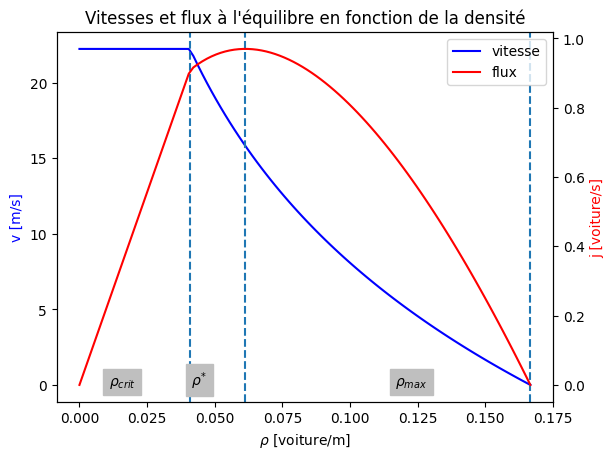

In [2]:
## ==== Constantes de modélisation ====
L = 6  #Longueur d'une voiture [m]
RHO_MAX = 1/L #Densité max [voiture/m]
V_MAX = 80/3.6 #Vitesse max [m/s]
RHO_STAR = 1/(L*np.exp(1)) #Densité optimale [voiture/m]
RHO_CRIT = RHO_STAR*2/3 #Densité critique [voiture/m]

## ==== Fonctions du modèle ====
def v(rho):
    '''Donne la vitesse d'équilibre pour une densité fixée [m/s]'''
    retVal = np.ones(len(rho)) * V_MAX
    retVal[rho > RHO_CRIT] = np.log(RHO_MAX/rho[rho > RHO_CRIT]) * V_MAX * 1/(np.log(RHO_MAX/RHO_CRIT))
    return retVal

def j(rho):
    '''Donne le flux à l'équilibre [voiture/s]'''
    return rho*v(rho)

## ==== Représentation graphique ====
x = np.linspace(0, RHO_MAX,100)

fig, ax1 = plt.subplots()
ax1.set_xlabel(r"$\rho$ [voiture/m]")
ax1.set_ylabel("v [m/s]", color = 'b')
ax1.plot(x,v(x), 'b-', label="vitesse")
ax1.axvline(x=RHO_CRIT,linestyle='--')
ax1.axvline(x=RHO_STAR,linestyle='--')
ax1.axvline(x=RHO_MAX,linestyle='--')

ax2 = ax1.twinx()
ax2.plot(x,j(x), color = 'r', label="flux")
ax2.set_ylabel("j [voiture/s]", color = 'r')

posTextY = 0
textFontSize = 10
plt.text(RHO_CRIT - 0.03, posTextY, r"$\rho_{crit}$", fontsize = textFontSize, backgroundcolor='0.75')
plt.text(RHO_STAR - 0.02, posTextY, r"$\rho^{*}$", fontsize = textFontSize, backgroundcolor='0.75')
plt.text(RHO_MAX - 0.05, posTextY, r"$\rho_{max}$", fontsize = textFontSize, backgroundcolor='0.75')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc=0)
plt.title("Vitesses et flux à l'équilibre en fonction de la densité")
plt.show()

On cherche maintenant à représenter graphiquement le profil de vitesse suite à un freinage de la première voiture. Je matérialise par une fonction le calcul de la position de la première voiture telle que décrite plus haut.

Pour la représentation graphique, j'utilise 2 vitesses arbitraires. La vitesse initiale est la vitesse maximale. La vitesse en fin de freinage est arbitrairement 70% de cette vitesse initiale. Le temps de freinage choisi est 2s.

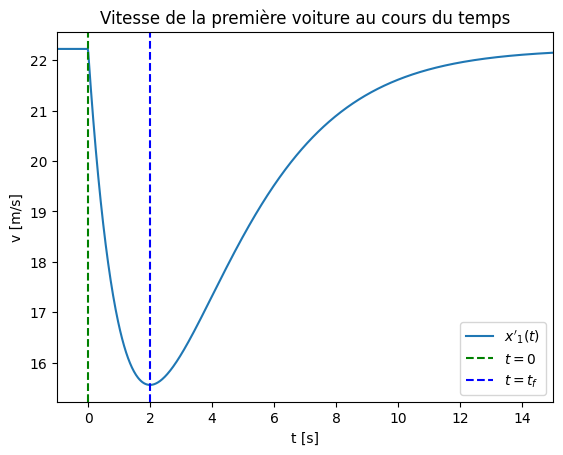

In [3]:
## ==== Variables de modélisation ====
# Vitesses initiale et de fin de freinage arbitraires
v_start = V_MAX # vitesse initiale [m/s]
v_end = v_start*0.7 # vitesse en fin de freinage [m/s]
t_f = 2 # temps de freinage [s]
k = 1/t_f * (1 - v_end/v_start) # Coefficient de freinage k [s^-1] 

## ==== Fonctions du modèle ====
def x_1_prime(t, k):
    '''Donne la vitesse de la voiture de tête pendant son freinage [m/s]'''
    retVal = np.ones(len(t)) * v_start
    retVal[t > 0] = v_start*(1 - k*t[t > 0]*np.exp((t_f-t[t > 0])/t_f))
    return retVal

## ==== Représentation graphique ====
t_l = np.linspace(-1,15,int(1e3))
y = x_1_prime(t_l, k)

plt.plot(t_l, y, label =r"$x'_{1}(t)$")
plt.axvline(x=0,color='green',linestyle='--', label = r"$t=0$")
plt.axvline(x=t_f,color='blue',linestyle='--', label = r"$t=t_f$")
plt.xlabel("t [s]")
plt.ylabel("v [m/s]")
plt.xlim(t_l[0], t_l[-1])
plt.legend()
plt.title("Vitesse de la première voiture au cours du temps")
plt.show()

> La voiture se déplace à la vitesse d'équilibre $v$ jusque $t=0$, elle freine pendant $t=t_f$ et ensuite reprend sa vitesse initiale.

Une visualisation de la fonction $\delta_{1}(t)$ qui nous donne l'évolution temporelle de la distance entre la position réelle de la voiture 1 après perturbation et la position qu'elle aurait occupée sans perturbation *i.e.* à l'équilibre :

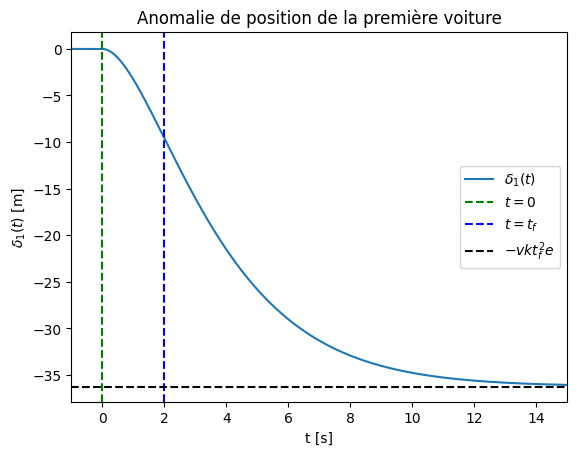

In [4]:
## ==== Fonctions du modèle ====
def delta_1(t, k, t_f, v_start): # On a calculé l'intégrale analytiquement (faisable)
    '''Renvoie l'anomalie de positionnement de la première voiture au cours du temps [m]'''
    retVal = np.zeros(len(t))
    retVal[t > 0] = -v_start*k*t_f*(t_f-(t[t > 0]+t_f)*np.exp(-t[t > 0]/t_f))*np.exp(1)
    return retVal

## ==== Représentation graphique ====
y = delta_1(t_l, k, t_f, v_start)
plt.plot(t_l, y, label =r"$\delta_{1}(t)$")
plt.axvline(x=0,color='green',linestyle='--', label = r"$t=0$")
plt.axvline(x=t_f,color='blue',linestyle='--', label = r"$t=t_f$")
plt.axhline(y=-v_start*k*t_f**2*np.exp(1),color='black',linestyle='--', label = r"$-vkt_{f}^{2}e$")
plt.xlabel("t [s]")
plt.ylabel(r"$\delta_{1}(t)$ [m]")
plt.xlim(t_l[0], t_l[-1])
plt.legend(loc = 'center right')
plt.title("Anomalie de position de la première voiture")
plt.show()

> La perturbation dans le temps concernant la première voiture quand elle a un profil de vitesse avec un freinage exponentiellement décroissant. On remarque qu'il y a un "gap" de distance de $vkt_{f}^{2}e$ entre la position de la voiture si elle n'avait pas freiné et sa position réelle.

Enfin, on cherche à représenter la propagation de la perturbation sur les voitures à l'arrière. On rappelle l'équation reliant l'anomalie de position aux paramètres du problème :

$$ \forall \ i \in [\![2,N]\!], \ \delta'_{i}(t+\tau) = v\ln\big( \rho_{max}[d + L + \delta_{i-1}(t)-\delta_{i}(t)]\big) - v $$

On souhaite utiliser une résolution numérique pour cette équation différentielle. On a pour conditions initiales : $\delta'_{i}(t<0) = 0$ et $\delta_{i}(t<0) = 0$.

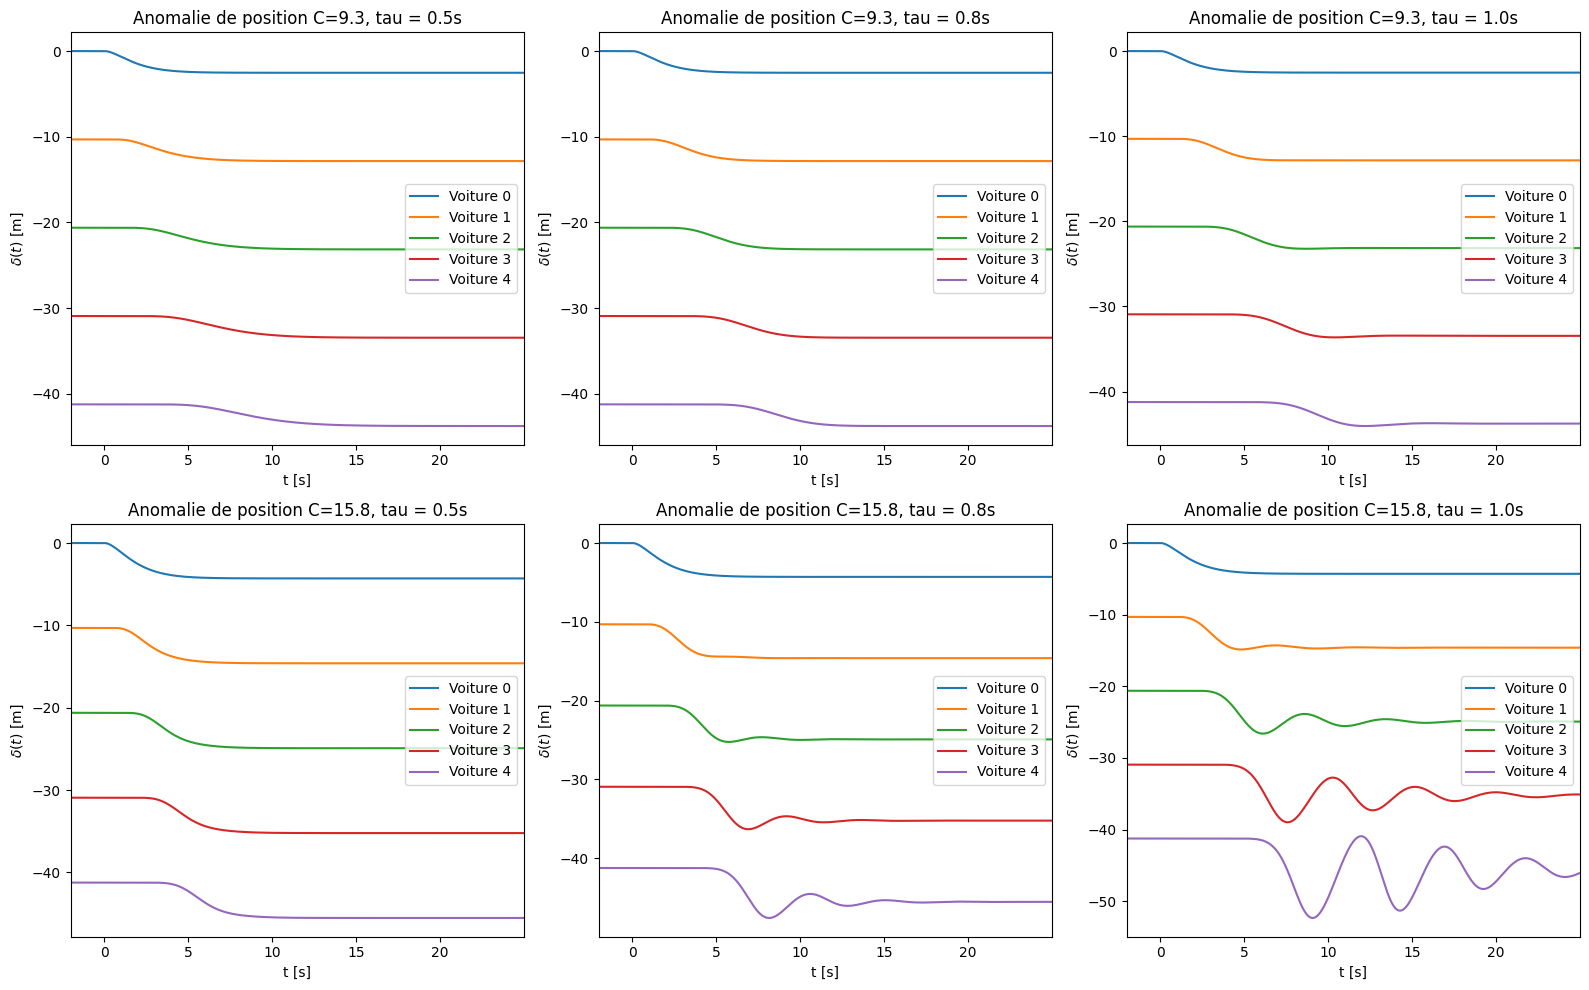

In [5]:
## ==== Constantes de simulation ====
DELTA_T = 0.02

## ==== Modélisation ====
def getCarPositionError(t_l, nb_car, d, L, v_eq, tau_mult, k, t_f):
    retVal = np.empty((nb_car, 2, len(t_l)))
    retVal[:,:,t_l<=0] = 0 # Conditions initiales
    i_start = 0
    while t_l[i_start] < 0 :
        i_start = i_start + 1

    # On calcule l'anomalie de position de la voiture 1
    retVal[0,0,:] = delta_1(t_l, k, t_f, v_eq)

    # Pour chaque voiture
    for car_num in range(1, nb_car):
        # Pour chaque instant
        for i in range(i_start, len(t_l)):
            # Calcul de la dérivée
            #print(f"I'm at {t_l[i]} and I look at {t_l[i-tau_mult]}")
            delta_im1_tmtau = retVal[car_num-1, 0, i-tau_mult]
            delta_i_tmtau = retVal[car_num, 0, i-tau_mult]
            if (d + L + delta_im1_tmtau - delta_i_tmtau < 0) :
                retVal[car_num, 1, i] = retVal[car_num, 1, i-1]
            else :
                retVal[car_num, 1, i] = v_eq*np.log(RHO_MAX * (d + L + delta_im1_tmtau - delta_i_tmtau)) - v_eq

            # Calcul de delta
            retVal[car_num, 0, i] = retVal[car_num, 0, i-1] + (retVal[car_num, 1, i] + retVal[car_num, 1, i-1])*DELTA_T/2
    return retVal

## ==== Paramètres de simulation ====
rho_exp = RHO_STAR
d = 1/rho_exp - L
nb_car = 5
t_start = -2
t_end = 25
t_l = np.arange(t_start,t_end,DELTA_T)
tau_mult = 50

def v(rho, rho_crit):
    '''Donne la vitesse d'équilibre pour une densité fixée [m/s]'''
    retVal = np.ones(len(rho)) * V_MAX
    retVal[rho > rho_crit] = np.log(RHO_MAX/rho[rho > rho_crit]) * V_MAX * 1/(np.log(RHO_MAX/rho_crit))
    return retVal

def executeGetCarPositionError(rho_crit, tau_mult):
    tau = tau_mult * DELTA_T
    v_eq = v(np.array([rho_exp]), rho_crit)[0]
    v_end = v_eq*0.9 # vitesse en fin de freinage [m/s]
    t_f = 1 # temps de freinage [s]
    k = 1/t_f * (1-(v_end/v_eq)) # Coefficient de freinage k [s^-1] 

    # print(f"k = {k:.1e}s^-1")
    # print(f"Tau = {tau:.1f}s")
    # print(f"d = {d:.1f}m")
    # print(f"v = {v_eq:.1f}m/s")
    # print(f"C = {V_MAX / np.log(RHO_MAX / RHO_CRIT)}")
    modelData = getCarPositionError(t_l, nb_car, d, L, v_eq, tau_mult, k, t_f)
    return modelData

## ==== Représentation graphique ====
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

RHO_CRIT = RHO_STAR*1/4 #Densité critique [voiture/m]
tau_mult = 500
modelData = executeGetCarPositionError(RHO_CRIT, tau_mult)
for i in range(nb_car):
    ax[0,0].plot(t_l, modelData[i,0,:] - i*d, label=f"Voiture {i}")
ax[0,0].set_title(f"Anomalie de position C={V_MAX / np.log(RHO_MAX / RHO_CRIT):.1f}, tau = {tau_mult * DELTA_T}s")

RHO_CRIT = RHO_STAR*1/4 #Densité critique [voiture/m]
tau_mult = 800
modelData = executeGetCarPositionError(RHO_CRIT, tau_mult)
for i in range(nb_car):
    ax[0,1].plot(t_l, modelData[i,0,:] - i*d, label=f"Voiture {i}")
ax[0,1].set_title(f"Anomalie de position C={V_MAX / np.log(RHO_MAX / RHO_CRIT):.1f}, tau = {tau_mult * DELTA_T}s")

RHO_CRIT = RHO_STAR*1/4 #Densité critique [voiture/m]
tau_mult = 1000
modelData = executeGetCarPositionError(RHO_CRIT, tau_mult)
for i in range(nb_car):
    ax[0,2].plot(t_l, modelData[i,0,:] - i*d, label=f"Voiture {i}")
ax[0,2].set_title(f"Anomalie de position C={V_MAX / np.log(RHO_MAX / RHO_CRIT):.1f}, tau = {tau_mult * DELTA_T}s")


RHO_CRIT = RHO_STAR*2/3 #Densité critique [voiture/m]
tau_mult = 500
modelData = executeGetCarPositionError(RHO_CRIT, tau_mult)
for i in range(nb_car):
    ax[1,0].plot(t_l, modelData[i,0,:] - i*d, label=f"Voiture {i}")
ax[1,0].set_title(f"Anomalie de position C={V_MAX / np.log(RHO_MAX / RHO_CRIT):.1f}, tau = {tau_mult * DELTA_T}s")

RHO_CRIT = RHO_STAR*2/3 #Densité critique [voiture/m]
tau_mult = 800
modelData = executeGetCarPositionError(RHO_CRIT, tau_mult)
for i in range(nb_car):
    ax[1,1].plot(t_l, modelData[i,0,:] - i*d, label=f"Voiture {i}")
ax[1,1].set_title(f"Anomalie de position C={V_MAX / np.log(RHO_MAX / RHO_CRIT):.1f}, tau = {tau_mult * DELTA_T}s")

RHO_CRIT = RHO_STAR*2/3 #Densité critique [voiture/m]
tau_mult = 1000
modelData = executeGetCarPositionError(RHO_CRIT, tau_mult)
for i in range(nb_car):
    ax[1,2].plot(t_l, modelData[i,0,:] - i*d, label=f"Voiture {i}")
ax[1,2].set_title(f"Anomalie de position C={V_MAX / np.log(RHO_MAX / RHO_CRIT):.1f}, tau = {tau_mult * DELTA_T}s")

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel("t [s]")
        ax[i,j].set_ylabel(r"$\delta(t)$ [m]")
        ax[i,j].set_xlim(t_l[0], t_l[-1])
        ax[i,j].legend(loc = 'center right')
plt.tight_layout(w_pad=1, h_pad=1)
plt.show()

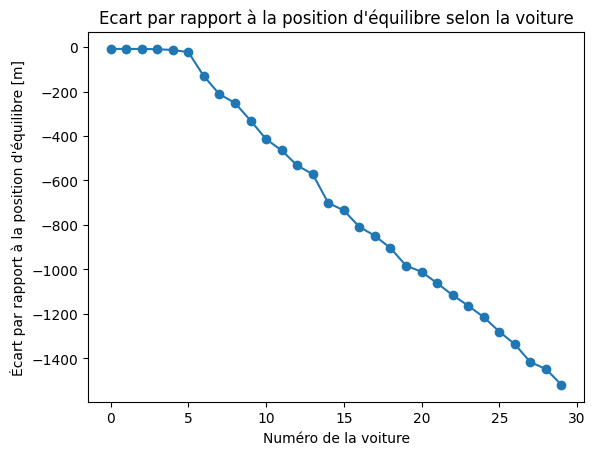

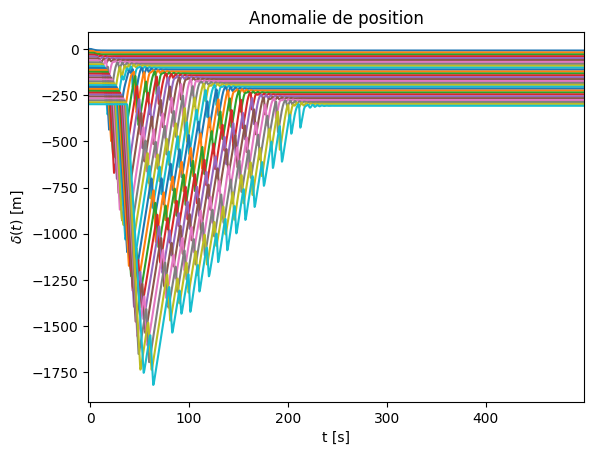

Exposant de Liapounov : 0.00


In [6]:
## ==== Paramètres de simulation ====
v_eq = v(np.array([rho_exp]), rho_crit=RHO_STAR*2/3)[0]
v_end = v_eq*(1 - 1e-1) # vitesse en fin de freinage [m/s]
k = 1/t_f * (1-(v_end/v_eq)) # Coefficient de freinage k [s^-1] 
nb_car = 60
t_start = -2
t_end = 500
t_l = np.arange(t_start,t_end,DELTA_T)

## ==== Représentation graphique ====
modelData = getCarPositionError(t_l, nb_car, d, L, v_eq, tau_mult, k, t_f)
car = range(nb_car)
difference = [modelData[i,0,np.argmin(modelData[i,0,:])] for i in car]

plt.plot(car,difference, marker ='o')
plt.xlabel("Numéro de la voiture")
plt.ylabel("Écart par rapport à la position d'équilibre [m]")
plt.title("Ecart par rapport à la position d'équilibre selon la voiture")
plt.show()

for i in range(nb_car):
    plt.plot(t_l, modelData[i,0,:] - i*d, label=f"Voiture {i}")
plt.xlabel("t [s]")
plt.ylabel(r"$\delta(t)$ [m]")
plt.xlim(t_l[0], t_l[-1])
#plt.legend(loc = 'center right')
plt.title("Anomalie de position")
plt.show()

difference = np.array(difference)
carstart = 40
l = np.sum(np.log(np.absolute(difference[carstart + 1:] - difference[carstart:-1]))) / (nb_car-1)
print(f"Exposant de Liapounov : {l:.2f}")

> Notre modèle nous dit donc que la perturbation initiale (c'est-à-dire le freinage exponentiellement décroissant) de la voiture en tête de file se propage aux autres voitures derrière. Cette perturbation engendre bien le ralentissement attendu des conducteurs. 

> Deux phénomènes à remarquer : plus on considère une voiture loin derrière dans la file, plus la perturbation s'intensifie.
Ensuite, plus le temps avance, plus le comportement des conducteurs devient contre-intuitif, ils avancent et reculent et ainsi de suite : c'est les oscillations des différentes courbes, et ce phénomène oscillatoire est encore plus marqué pour les voitures à l'arrière. 

## 2) Modèle macroscopique fluide<a id='fluid_id'></a>

### Présentation<a id='fluid_pres_id'></a>


Il s'agit ici de voir un modèle macroscopique traitant du trafic comme de l'étude d'un fluide. Une observation liminaire consiste à dire que lorsqu'on regarde le trafic de très loin, le déplacement macroscopique des véhicules s'apparente à l'écoulement d'un fluide. On peut supposer que le mouvement macroscopique des véhicules ressemble à l'écoulement d'un fluide compressible à une dimension.
    
**Hypothèses faites :**
- Les conducteurs respectent les règles du code
- La longueur des voitures est la même
- Le flux du trafic est conservé (équation de continuité) : aucune voiture n'est créée de nulle part ni détruite.
- On suppose que le nombre de voitures est assez grand pour que la densité moyenne et le flux moyen soient des fonctions de classe $\mathcal{C^1}$ d'espace et de temps.
    
**Définition des variables :**
- Densité : $\overrightarrow{\rho}(x,t)$ : nombre de voitures par unité de longueur à un instant $t$
- Densité de flux : $\overrightarrow{j}$ : nombre de voitures dépassant un point donné par unité de temps.
- Vitesse : $\overrightarrow{v}(x,t)$
- On a : $\overrightarrow{j} = \rho \cdot \overrightarrow{v}$

### Modèle et équations<a id='fluid_equations_id'></a>

On rappelle l'équation de continuité : $$\frac{\partial \rho}{\partial t} +\overrightarrow{\nabla}\cdot \overrightarrow{j}=0 \quad ,$$
avec $\overrightarrow{\nabla}\cdot$ l'opérateur divergence.
    
A une dimension, cela se ramène à : $$\frac{\partial \rho}{\partial t} + \frac{\partial j}{\partial x} =0$$

On a besoin d'une condition initiale : la densité initiale, à $t=0$, $$\rho(x,0)=\rho_0$$ 
    
Par ailleurs, cette EDP d'ordre 1 est résolvable, si $v = v(\rho)$, on aura alors deux équations exploitables.
    
On peut résoudre analytiquement (courbes caractéristiques) ou numériquement.
    
Examinons les propriétés que devrait satisfaire la relation vitesse et densité :
- $\frac{\mathrm{d}v}{\mathrm{d}\rho}<0$ : $v$ devrait être une fonction décroissante de la densité.
- $v=v_{max}$ lorsque $\rho =0$
- $v=0$ lorsque $\rho = \rho_{max}$
    
- **Modèle de Greenshield** : une première approche pourrait être de supposer qu'il existe une relation linéaire entre $v$ et $\rho$ telle que : 

$$v = v_{max}(1-\frac{\rho}{\rho_{max}})$$

On vérifie aisément que les trois conditions sur la relation entre vitesse et densité sont vérifiées.
On a par ailleurs : 
    
$$j = v_{max}(\rho - \frac{\rho^2}{\rho_{max}})$$

On pourra faire un graphique de $v$ en fonction de $\rho$,et également de $j$ en fonction de $\rho$.
On vérifie aisément que le maximum de $j$ est atteint en $\rho = \frac{\rho_{max}}{2}$ et vaut $j_{max} = \frac{v_{max}\rho_{max}}{4}$.

- **Modèle de Greenberg** : $$v = v_{max}\log(\frac{\rho_{max}}{\rho}) \quad ,$$ on a bien les trois conditions qui sont vérifiées.
On a par ailleurs : 

$$j = v_{max}\rho\log(\frac{\rho_{max}}{\rho}) $$

- **Modèle de Underwood** : $$v = v_{max}\exp(-\frac{\rho}{\rho_{max}})$$
On a : 

$$j = v_{max}\rho\exp(-\frac{\rho}{\rho_{max}}) $$

Concentrons-nous sur un modèle : celui de Lighthill, Whitham et Richards. On fait en fait référence à une "classe de modèles LWR", qui repose chacun sur l'équation de continuité, ces modèles sont dit de 1er ordre, les modèles de 2nd ordre ajoutent une équation pour la vitesse qui se comporte comme une  quantité indépendante de $\rho$. On utilisera par la suite les relations données par le modèle de  Greenshield.

**Modèle LWH** :

On suppose d'abord que : 

$$ j(x,t)= j(\rho(x,t)) \quad \text{ou encore} \quad v(x,t)=v(\rho(x,t)) $$

Autrement dit, le modèle LWH suppose que le flux et la vitesse (locale) répondent instantanément à la densité (relation bijective), que ce soit à l'équilibre ou hors-équilibre. 

On part alors de l'équation de continuité : 

$$\frac{\partial \rho}{\partial t} + \frac{\mathrm{d}j(\rho)}{\mathrm{d}\rho} \frac{\partial \rho}{\partial x} =0$$

Ou encore : 

$$ \frac{\partial \rho}{\partial t} + \big(v + \rho\frac{\mathrm{d}v}{\mathrm{d}\rho} \big) \frac{\partial \rho}{\partial x} =0 $$

Pour déterminer la célérité de l'onde, on se propose d'utiliser la méthode classique qui consiste à poser : 

$$\rho(x,t) = \rho_0(x-ct)$$

La fonction $\rho_0(x) = \rho(x,0)$ correspond à la distribution initiale de densité, qui se déplace à la vitesse c. 

En calculant sa dérivée et en substituant dans l'équation LWR, on a : 

$$ \forall (x,t) \quad , \quad -c\rho_{0}^{'}(x-ct) + \frac{\mathrm{d}j}{\mathrm{d}\rho}\rho_{0}{'}(x-ct) = 0 $$

Ce qui n'est possible que si la célérité $c$ est telle que : 

$$ c(\rho) = \frac{\mathrm{d}j}{\mathrm{d}\rho} $$

C'est-à-dire que la vitesse de propagation des variations de densité $c(\rho)$ est proportionnelle au gradient de la relation liant flux et densité à l'équilibre.  

On cherche maintenant la relation entre la vitesse de propagation et la vitesse de la voiture $v$, pour cela on définit une vitesse de propagation relative du point de vue du conducteur (point de vue Lagrangien de mécanique des fluides) :

$$ c_{relatif}(\rho) = c(\rho) - v = c(\rho) - v(\rho) = \rho v^{'}(\rho)$$

Or par hypothèse $v^{'}(\rho) \le 0$, on a donc $c_{relatif} \le 0$.

Du point de vue du conducteur, les variations de densité se propagent toujours vers l'arrière (ou alors sont stationnaires).

Un modèle LWR décrit des variations de densité constantes mais des variations de vitesse de propagation locale non constante : plus la densité locale est faible, plus la vitesse de propagation est grande. 

On peut essayer d'illustrer la densité selon la position à un instant $t$ donné (cf *infra*). 

On peut dire que l'évolution du conducteur sera celle d'une particule matérielle qui se déplace sur la surface d'une vague, en haut de la vague il aura une vitesse plus grande qu'en bas de celle-ci. Pour une vague type "stop and go" comme le phénomène qu'on a vu dans le modèle 1, l'amont de la vague deviendra plus raide, tandis que l'aval s'applatira. De son point de vue, la transition "trafic fluide $\to$ bouchon" devient de plus en plus abrupte, tandis que les voitures se trouvant dans la transition "bouchons $\to$ trafic fluide" vont accélerer de plus en plus lentement au cours du temps. Le gradient $\frac{\partial \rho}{\partial x}$ va tendre vers l'infini à l'amont de la vague (la vague devient quasi-droite), la situation devient non-physique : on ne peut avoir qu'une seule densité à un $(x,t)$ donné.

Mathématiquement, cela revient à dire que $j^{"}(\rho) \lt 0$, la fonction de flux doit être concave pour respecter cet aspect physique du problème. 

### Modélisation numérique<a id='fluid_modnum_id'></a>

Une visualisation des relations flux-densité et vitesse de la voiture/célérité-densité, ainsi que l'évolution de la densité :

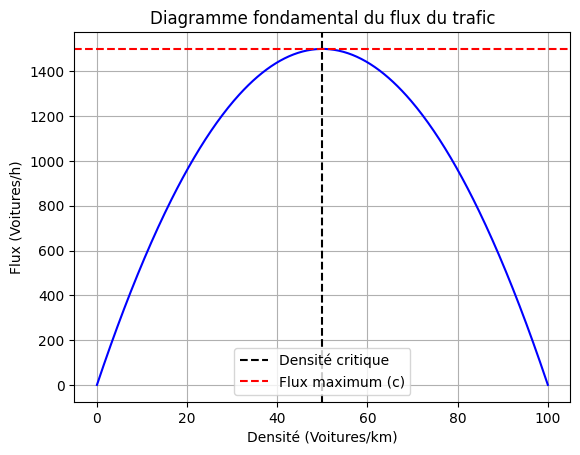

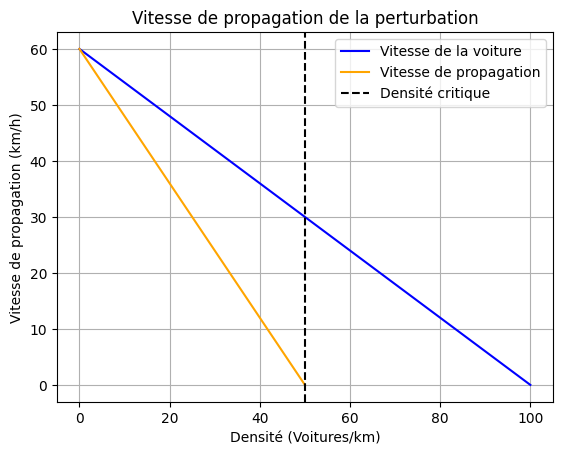

In [7]:
v_max = 60
rho_max = 100

def vitesse(rho): # Modèle Greenshield
    return v_max*(1-rho/rho_max)

# Densité
rho = np.linspace(0, rho_max,400)

flux = rho*vitesse(rho)
densite_crit = rho_max/2
flux_max = densite_crit*vitesse(densite_crit)

plt.plot(rho, flux, color='blue')
plt.axvline(x=densite_crit, color='black', linestyle='--', label='Densité critique')
plt.axhline(y=flux_max, color='red', linestyle='--', label='Flux maximum (c)')
plt.xlabel('Densité (Voitures/km)')
plt.ylabel('Flux (Voitures/h)')
plt.title('Diagramme fondamental du flux du trafic')
plt.legend()
plt.grid(True)
plt.show()

rho_c = np.linspace(0,densite_crit,400)
vitesse_propagation = v_max*(1 - 2*rho_c/rho_max)
plt.plot(rho, vitesse(rho), label='Vitesse de la voiture', color='blue', linestyle='-')
plt.plot(rho_c, vitesse_propagation, label='Vitesse de propagation', color = 'orange')
plt.axvline(x=densite_crit, color ='black', linestyle='--', label='Densité critique')
plt.xlabel('Densité (Voitures/km)')
plt.ylabel('Vitesse de propagation (km/h)')
plt.title('Vitesse de propagation de la perturbation')
plt.legend()
plt.grid(True)
plt.show()

Regardons comment la perturbation se propage, on se propose de résoudre numériquement l'EDP par une méthode des différences finies :

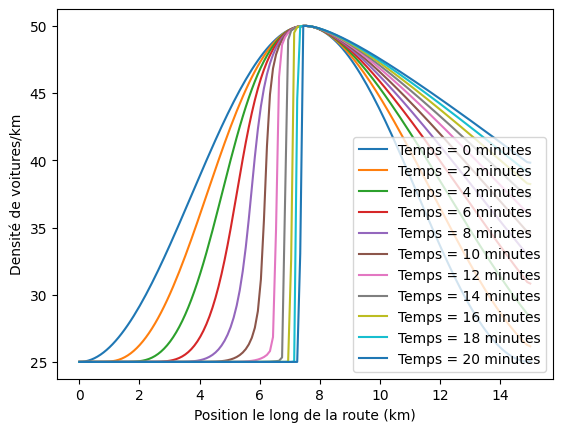

In [8]:
v_max = 60 # Vitesse max en km/h
rho_max = 100 # Densité max (voitures par km)
L=15 # Longueur de la route en km
dx = 0.1 # Step pour la route, en km
dt = dx/v_max # Step pour le temps, en heures
T = 0.35 # Temps de simulation, en heures
N = int(L/dx) # Nombres d'abcisses spatiales
M = int(T/dt) # Nombres de step de temps

def vitesse(rho): # Modèle Greenshield
    return v_max*(1-rho/rho_max)

# Condition initiale
x = np.linspace(0,L,N)
rho_initial = 25*(1+np.sin(np.pi*x/L)**2)

# Simulation 
rho = np.copy(rho_initial)
rhos = [rho.copy()]

for t in range(M):
    v = vitesse(rho)
    new_rho = np.copy(rho)
    
    for i in range(1,N-1): # Méthode des différences finies 
        new_rho[i] = rho[i] - dt/dx * (v[i] * (rho[i]-rho[i-1]) + rho[i]*(v[i] - v[i-1]))
    
    # Conditions aux limites
    new_rho[0] = rho[0] - dt/dx * (v[0]*(rho[0]-rho[0])) # pas de flux entrant au début
    new_rho[-1] = rho[-2] # le flux sortant est extrapolé avec la valeur d'avant
    
    rho=new_rho
    rhos.append(rho.copy())

fig, ax = plt.subplots()
for i in range(0,M, int(M/10)):
    ax.plot(x, rhos[i], label=f'Temps = {60*i*dt:.0f} minutes')
ax.set_xlabel('Position le long de la route (km)')
ax.set_ylabel('Densité de voitures/km')
ax.legend(loc = 'lower right')
plt.show()

> On observe un phénomène d'onde de choc, la densité du trafic change de manière brutale, puis la densité de trafic diminue progerssivement, cela traduit la formation de la congestion et son éventuelle dissipation. On voit comment la distribution initiale de densité (avec la congestion) se propage le long de la route.  

> Le modèle n'est valable que sur une simulation avec un temps court, plus le temps s'allonge plus les approximations numériques deviennent grossières et produisent un résultat non physique.

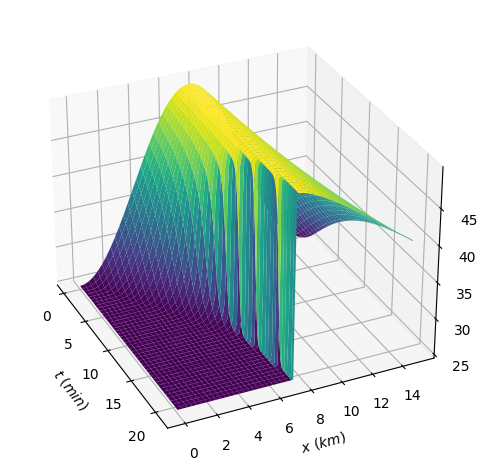

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Paramètres
v_max = 60 # Vitesse max en km/h
rho_max = 100 # Densité max (voitures par km)
L=15 # Longueur de la route en km
dx = 0.1 # Step pour la route, en km
dt = dx/v_max # Step pour le temps, en heures
T = 0.35 # Temps de simulation, en heures
N = int(L/dx) # Nombres d'abcisses spatiales
M = int(T/dt) # Nombres de step de temps

def vitesse(rho):
    return v_max*(1-rho/rho_max)

# Condition initiale
x = np.linspace(0,L,N)
rho_initial = 25*(1+np.sin(np.pi*x/L)**2)

# Simulation 
rho = np.copy(rho_initial)
rhos = [rho.copy()]

for t in range(M):
    v = vitesse(rho)
    new_rho = np.copy(rho)
    
    for i in range(1,N-1): # Méthode des différences finies 
        new_rho[i] = rho[i] - dt/dx * (v[i] * (rho[i]-rho[i-1]) + rho[i]*(v[i] - v[i-1]))
    
    # Conditions aux limites
    new_rho[0] = rho[0] - dt/dx * (v[0]*(rho[0]-rho[0])) # pas de flux entrant au début
    new_rho[-1] = rho[-2] # le flux sortant est extrapolé avec la valeur d'avant
    
    rho=new_rho
    rhos.append(rho.copy())
    
# Données 3D
Y, X = np.meshgrid(x, np.arange(M+1)*60*dt) # Conversion du temps en minutes
Z = np.array(rhos)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X,Y,Z, cmap='viridis')

ax.set_xlabel(r'$t \ (min)$')
ax.set_ylabel(r'$x \ (km)$')
ax.set_zlabel(r'$\rho \ (voitures/km)$')
fig.tight_layout()
ax.view_init(elev=30, azim = -25)
plt.show()

> Solution numérique au modèle LWR avec un profil de vitesse de Greenshield, une distribution initiale sinusoïdale (partie la plus au fond du plot). On a une région localisée de bouchon (en jaune) entourée par un trafic non perturbé (bleu). La transition "trafic fluide $\to$ bouchon" évolue en une onde de choc tandis que la transition "bouchon $\to$ trafic fluide" se disperse. L'instant où l'onde de choc se forme se trouve vers $t \simeq 10 \ \text{min}$ et $x \simeq 6 \ \text{km}$.

## 3) Modèle discret de la route<a id='road_id'></a>

### Présentation du modèle<a id='road_pres_id'></a>

On s'intéresse à la modélisation d'une portion de route droite à une seule voie. On souhaite faire évoluer continuellement des voitures sur cette route. Cette modélisation sert de cadre d'exécution pour le modèle du conducteur. Je cherche donc à séparer l'input d'accélération du reste du modèle.

Je représente chaque voiture de manière discrète par sa position, sa longueur et sa vitesse. L'accélération étant fournie, le but de ce modèle est de trouver la vitesse et la position.

Dans un premier temps, je m'intéresse à la représentation possible d'une voiture sur une route circulaire. Je choisis une route circulaire de taille 1km, et une voiture se déplaçant à 30 km.h-1. J'identifie sa position à l'instant t par la distance parcourue depuis le temps t=0 modulo 1 tour de boucle.

### Équations du modèle<a id='road_equations_id'></a>

Comme l'accélération maximale et la force maximale de freinage sont finies, la vitesse est une fonction continue du temps. On est donc en présence des équations de base du mouvement. On fournit $a(t)$ comme une fonction du temps. Par forcément continue, mais bornée. Les équations de la vitesse et de la position sont :

$$ 
v(T) = v_0 + \int_{t=0}^Ta(t)
$$
$$
d(T) = d_0 + \int_{t=0}^Tv(t)
$$

### Modèle numérique<a id='road_modnum_id'></a>

On cherche ici à résoudre numériquement ces intégrales pour n'importe quelle fonction d'accélération. Je crée une fonction qui permet d'obtenir la distance parcourue, la vitesse et l'accélération (tangentielle) de la voiture à des instants donnés. Je choisis pour cela la méthode d'intégration par les trapèzes.

Il est important de définir le sens des valeurs fournies par cette modélisation. On considère des valeurs initiales de position et de vitesse qui vont permettre au conducteur de prendre une décision pour la première accélération. Cette accélération sera constante sur l'intervalle de temps de la simulation. C'est l'input de l'utilisateur pour un intervalle de temps et il faut attendre l'intervalle suivant pour que le conducteur puisse choisir une nouvelle valeur d'accélération. L'accélération est donc une fonction en escalier. L'intégration se fait simplement par la méthode des rectangles à droite. La vitesse ainsi calculée est une fonction linéaire par morceau.

Pour la position, on utilise la méthode des trapèzes puisque la vitesse est linéaire par morceaux. On obtient ainsi la vitesse et la position modélisées pour l'instant t.

J'ajoute comme contrainte que la vitesse ne peut pas être négative. L'accélération peut être négative, mais la vitesse restera à 0.

In [10]:
# ==== Modélisation et résolution numérique ====

def getMultipleCarKinematics(l_t, nbCar, l_getCarAccel, v_ini):
    '''
    Donne la position de la voiture à partir d'une liste d'instants (en secondes)
        - nbCar le nombre de voitures à simuler
        - l_getCarAccel donne l'accélération choisie en fonction des paramètres pour chaque voiture
        - v_ini est le vecteur d'initialisation de la position et de la vitesse de chaque voiture

    Attention, pour que l'algorithme de décision fonctionne au mieux, il faut fournir en premier la voiture de tête puis dans l'ordre décroissant de position

    retourne un tableau numpy 3D. La première dimension identifie la voiture. La seconde dimension nous donne :
        - en indice 0 le tableau des positions
        - en indice 1 le tableau des vitesses
        - en indice 2 le tableau des accélérations
    La troisième dimension est le temps.
    '''
    retVal = np.empty((nbCar, 3, len(l_t)))
    
    # Conditions initiales
    retVal[:, 0:2, 0] = v_ini
    delta_t = l_t[1] - l_t[0]
    
    # On utilise une approche instant par instant pour que la voiture puisse réagir à la situation présentée
    for i in range(len(l_t)) :
        for carNum in range(nbCar) :
            # On intègre par la méthodes des rectangles à droite et des trapèzes
            if (i > 0) :
                # Max avec 0 pour assurer une vitesse positive ou nule
                retVal[carNum, 1, i] = max(0, retVal[carNum, 1, i-1] + retVal[carNum, 2, i-1] * delta_t) 
                retVal[carNum, 0, i] = retVal[carNum, 0, i-1] + (retVal[carNum, 1, i] + retVal[carNum, 1, i-1]) * delta_t / 2
            
            # On calcule la réaction du conducteur à ces conditions
            retVal[carNum, 2, i] = l_getCarAccel[carNum](l_t[i], delta_t, retVal[:, :, :i+1], carNum)
    return retVal

À partir de ces données, je peux tracer la position de la voiture en fonction du temps, sa vitesse et son accélération. Je vais avoir besoin de régulièrement afficher ces graphes alors je crée une fonction à cet effet. Pour tester l'affichage, j'utilise 3 cas simples : accélération nulle, accélération constante et freinage constant.

On peut alors vérifier : 
- L'affichage en modulo d'un tour
- L'intégration d'une accélération voulue
- La limite empêchant la vitesse négative

Ce cadre d'exécution nous permet d'intégrer des algorithmes de décision pour le conducteur.

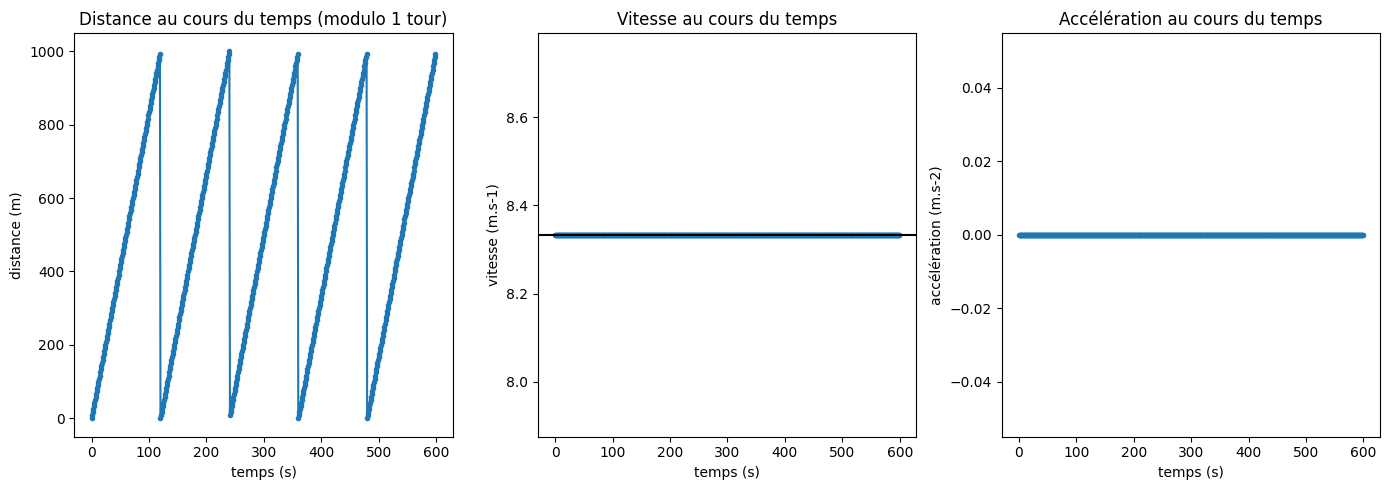

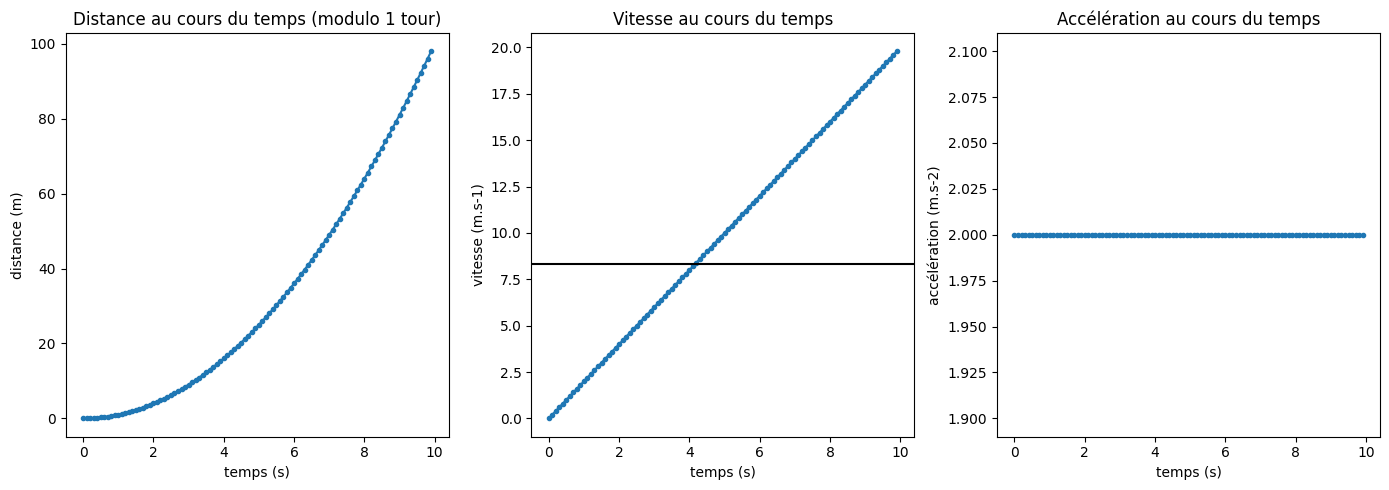

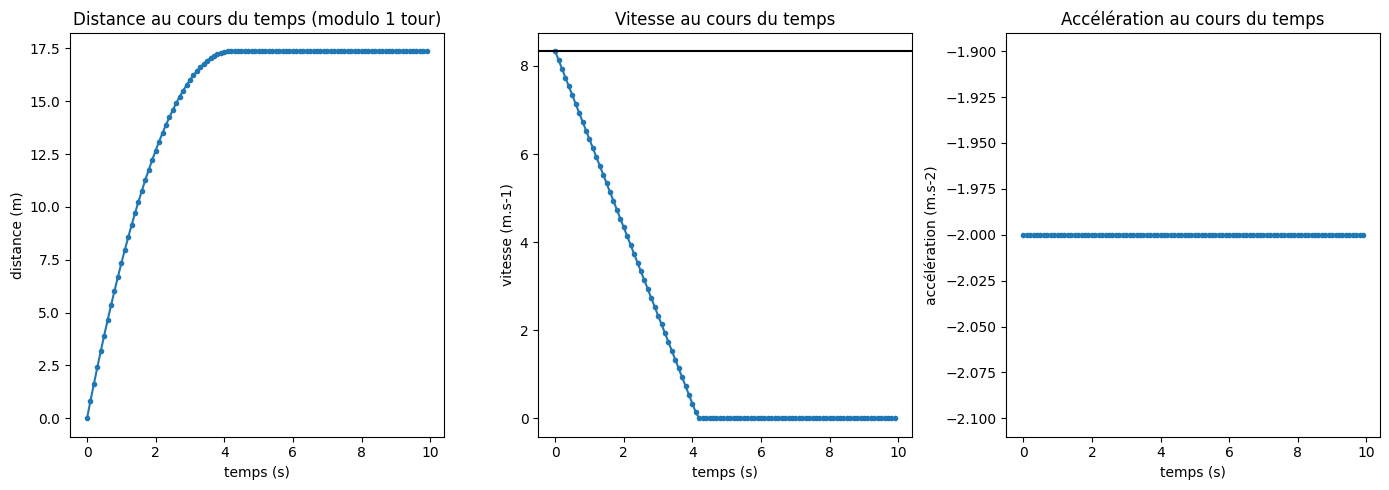

In [11]:
# ================================================================================
# Affichage
# ================================================================================

def showCarKinematics(np_carKinematics, trackLen, maxSpeed):
    # configuration de la grille de plots
    fig, axs = plt.subplots(1, 3, figsize=(14, 5)) 
    nbCar = np_carKinematics.shape[0]
    
    for car in range(nbCar):
        axs[0].plot(np_times, np.mod(np_carKinematics[car, 0, :], trackLen), '.-', label=f'v{car}')
        axs[0].set_title('Distance au cours du temps (modulo 1 tour)')
        axs[0].set_xlabel('temps (s)')
        axs[0].set_ylabel('distance (m)')
        
        axs[1].plot(np_times, np_carKinematics[car, 1, :], '.-', label=f'v{car}')
        axs[1].set_title('Vitesse au cours du temps')
        axs[1].set_xlabel('temps (s)')
        axs[1].set_ylabel('vitesse (m.s-1)')
        axs[1].axhline(maxSpeed, color='black')
        
        axs[2].plot(np_times, np_carKinematics[car, 2, :], '.-', label=f'v{car}')
        axs[2].set_title('Accélération au cours du temps')
        axs[2].set_xlabel('temps (s)')
        axs[2].set_ylabel('accélération (m.s-2)')
    
    if (nbCar > 1 and nbCar < 15):
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
    plt.tight_layout(w_pad=1, h_pad=1)
    plt.show()

# Exemples
def algo_carAccelNone(t, delta_t, vect, car_num) :
    return 0
    
def algo_carAccelConst(t, delta_t, vect, car_num) :
    return 2
    
def algo_carBreakConst(t, delta_t, vect, car_num) :
    return -2

maxSpeed = 30/3.6
trackLen = 1000
np_times = np.arange(0, 60*10, 1) # en secondes
showCarKinematics(getMultipleCarKinematics(np_times, 1, [algo_carAccelNone], [0,maxSpeed]), trackLen, maxSpeed)
np_times = np.arange(0, 10, 0.1) # en secondes
showCarKinematics(getMultipleCarKinematics(np_times, 1, [algo_carAccelConst], [0,0]), trackLen, maxSpeed)
np_times = np.arange(0, 10, 0.1) # en secondes
showCarKinematics(getMultipleCarKinematics(np_times, 1, [algo_carBreakConst], [0,maxSpeed]), trackLen, maxSpeed)

## 4) Modèle d'accélération constante<a id='constA_id'></a>

### Présentation du modèle<a id='constA_pres_id'></a>

Je cherche maintenant à coder un algorithme qui simule la prise de décision d'un automobiliste. L'automobiliste se comporte comme un automate déterministe qui connaît la distance avec une ou plusieurs voitures autour de lui et la vitesse relative. Cet automate interagit avec la voiture seulement en freinant ou en accélérant. On se donne un cadre de modélisation général qui prend en compte plusieurs critères du comportement d'un automobiliste :
- La vitesse de réaction qui se traduit par un délai entre l'événement induisant une réaction et l'application de l'action par l'automobiliste
- L'accélération maximale / La force maximale de freinage
- La vitesse maximale
- L'écart de temps minimal avec les voitures précédentes

Ce modèle s'inspire du travail réalisé par alokin-fr dans sa modélisation du trafic routier : [road-traffic-simulation](#doc_pythonIDM_id). Il propose une implémentation en python du modèle [Intelligent Driver Model](#doc_IDM_id). Je simplifie ici le modèle en considérant à chaque instant où l'automobiliste doit prendre une décision que la vitesse de la voiture devant est constante. On a alors l'accélération de la voiture qui nous précède qui vaut 0. L'accélération ainsi prévue à chaque instant est constante. Cependant, comme le calcul est répété à chaque instant, l'accélération globale dans la simulation est variable.

On va chercher au préalable à étudier l'impact des différents paramètres de modélisation sur le comportement de l'automobiliste.

Je cherche maintenant à faire évoluer le comportement de la voiture. Je souhaite que la voiture accélère avec une accélération constante jusqu'à une vitesse maximale de 30 km.h-1 puis qu'elle stabilise sa vitesse.

À cet effet, nous allons faire une simulation instants par instants. À $t=0$ on a la voiture qui est immobile à la position 0. Ensuite, le conducteur va appliquer pendant un intervalle donné une accélération à la voiture. Accélération choisie en fonction de sa vitesse et de sa position actuelle. Cette accélération est limitée par les caractéristiques de la voiture à savoir :
- L'accélération maximale
- Le freinage maximal
- Le seuil d'accélération applicable par le conducteur
- La force de freinage minimale appliquée par le conducteur (en dessous de cette force, le conducteur laisse la voiture avancer)

### Équations du modèle<a id='constA_equations_id'></a>

Pour cette modélisation, on considère que le conducteur va accélérer au maximum des capacités de la voiture sans pour autant dépasser la vitesse limite. Il cherche alors à atteindre la vitesse max en un intervalle de temps. Ce qui équivaut à résoudre l'équation suivante :
$$
V_max = V + a\Delta t
$$
$$
\Leftrightarrow a = \frac{V_max - V}{\Delta t}
$$

Je souhaite également que la voiture ralentisse si un obstacle se présente, et s'arrête avant l'obstacle. Je place une voiture immobile à la position 150 mètres. Je souhaite que la voiture commence à freiner à l'approche de cet obstacle et s'arrête juste avant.

On cherche à trouver la force de freinage constante à appliquer pour arriver à une vitesse de 0 proche de l'obstacle. On pose les équations du mouvement uniformément accéléré :

$$
\left\{ \begin{array}{c}
v = v_0 + at \\
d = d_0 + v_0t + \frac{1}{2}at^2 \\
\end{array} \right.
$$

On souhaite une vitesse finale nulle à une distance qui correspond à la distance avec l'obstacle. On peut donc définir $T$ comme le temps nécessaire à cette décélération. On obtient alors :

$$
\left\{ \begin{array}{c}
0 = v_0 + aT \\
d_{obstacle} = d_0 + v_0T + \frac{1}{2}aT^2 \\
\end{array} \right.
$$

$$
\Leftrightarrow \left\{ \begin{array}{cl}
T = -\frac{v_0}{a} \\
a = - 1/2\frac{v_0^2}{d_{obstacle} - d_0} \\
\end{array} \right.
$$

### Modélisation numérique<a id='constA_modnum_id'></a>

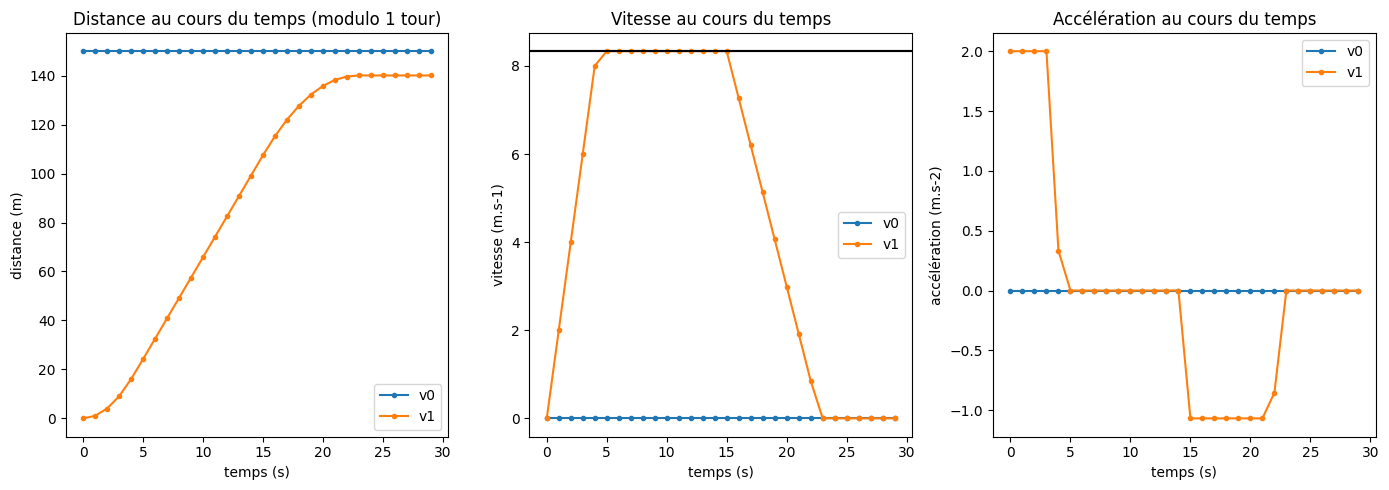

In [12]:
## ==== Paramètres de modélisation ====

# Caractéristiques de la voiture
accelMax = 2 #m.s-2
breakMax = 10 #m.s-2

# Caractéristiques du conducteur
accelMin = 0.2 #m.s-2
breakMin = 1 #m.s-2
distanceMin = 10 #m

# Caractéristiques de la route
maxSpeed = 30/3.6
trackLen = 1000

# ==== Algos de décision ====

def algo_simpleCar(t, delta_t, vect, carNum) :
    # Donne la vitesse de la voiture actuelle
    currentSpeed = vect[carNum, 1, -1]
    # Donne l'index de la voiture devant (pourait être amélioré en considérant la liste des positions)
    prevCarNum = carNum-1
    # Donne la distance relative avec la voiture de devant (moins la distance de sécurité)
    relDis = vect[prevCarNum, 0, -1] - vect[carNum, 0, -1] - distanceMin
    # Donne la vitesse relative avec la voiture de devant
    relSpeed = vect[prevCarNum, 1, -1] - vect[carNum, 1, -1]

    # On calcule le freinage voulu pour atteindre une vitesse de 0 à la distance relDis
    if (relSpeed < 0) :
        T = np.abs(2 * relDis/relSpeed) # Le temps caractéristique du freinage
        if (T < delta_t) : # Si plus petit qu'intervalle de simulation on utilise une autre formule (évite les divisions par 0 et changements infinitésimaux)
            desiredAccel = relSpeed / delta_t
            return desiredAccel
        
        desiredBreaking = np.abs((1/2) * (relSpeed**2)/relDis)
        if (desiredBreaking >= breakMin): # Si la voiture est assez proche pour tomber dans l'intervalle [breakMin, breakMax]
            return -min(desiredBreaking, breakMax)

    # S'il y a une voiture proche et qu'accélérer entraine une collision, on accélère pas
    if ((relSpeed + accelMin * delta_t) * delta_t > relDis) :
        return 0

    # Enfin, si la voie est libre, on calcule l'accélération voulue pour atteindre la vitesse cible en un intervalle de temps
    desiredAccel = min((maxSpeed - currentSpeed) / delta_t, accelMax)
    if (desiredAccel < accelMin):
        return 0
    return desiredAccel


# On affiche la nouvelle cinématique
np_times = np.arange(0, 30, 1) # en secondes
initV = np.empty((2, 2))
initV[0, :] = [150,0] # voiture stationaire
initV[1, :] = [0,0] # voiture en mouvement
showCarKinematics(getMultipleCarKinematics(np_times, 2, [algo_carAccelNone, algo_simpleCar], initV), trackLen, maxSpeed)

Observons maintenant le comportement de la voiture quand elle suit une autre voiture avec une vitesse inférieure à la vitesse maximale. Je modélise 2 voitures :
- Une voiture pilote avec une vitesse constante et qui part de la position 50 mètres.
- Une voiture conduite par le conducteur simulé

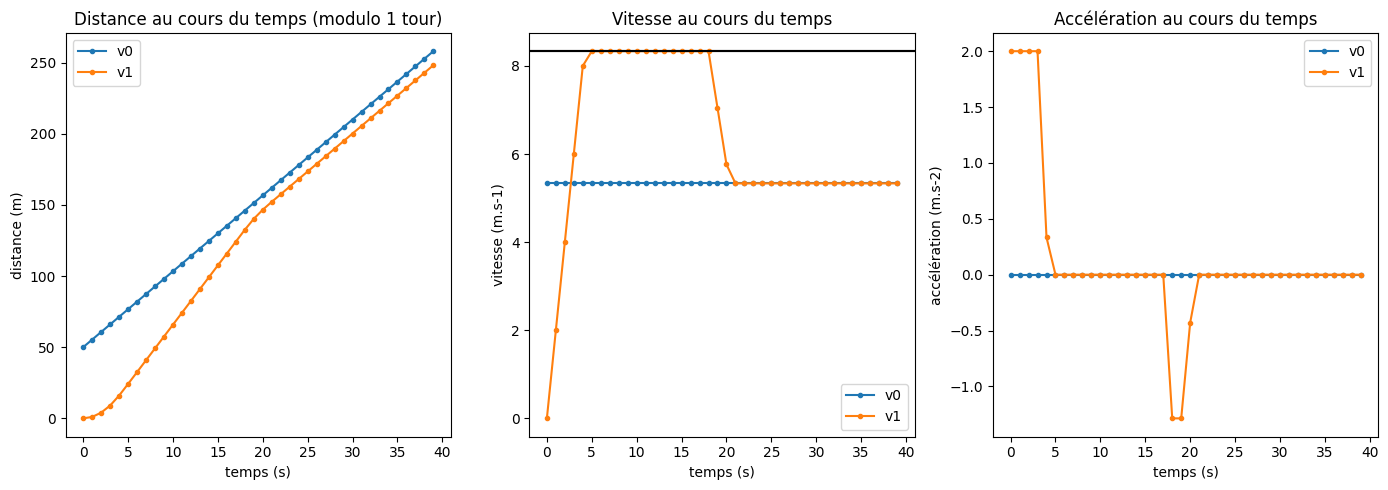

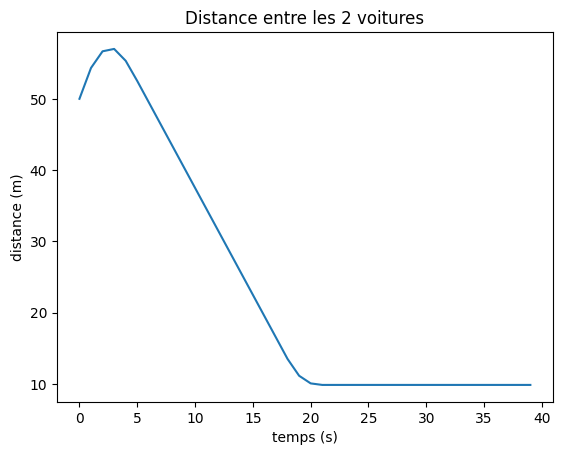

In [13]:
# On affiche la nouvelle cinématique
np_times = np.arange(0, 40, 1) # en secondes
initV = np.empty((2, 2))
initV[0, :] = [50,maxSpeed - 3] # voiture en vitesse constante
initV[1, :] = [0,0] # voiture en mouvement
np_carKinematics = getMultipleCarKinematics(np_times, 2, [algo_carAccelNone, algo_simpleCar], initV)
showCarKinematics(np_carKinematics, trackLen, maxSpeed)

# On affiche la distance séparant les 2 voitures
plt.plot(np_times, np_carKinematics[0, 0, :] - np_carKinematics[1, 0, :])
plt.title("Distance entre les 2 voitures")
plt.xlabel('temps (s)')
plt.ylabel('distance (m)')
plt.show()

On peut maintenant faire jouer la simulation pour plusieurs voitures comme pour la modélisation précédente.

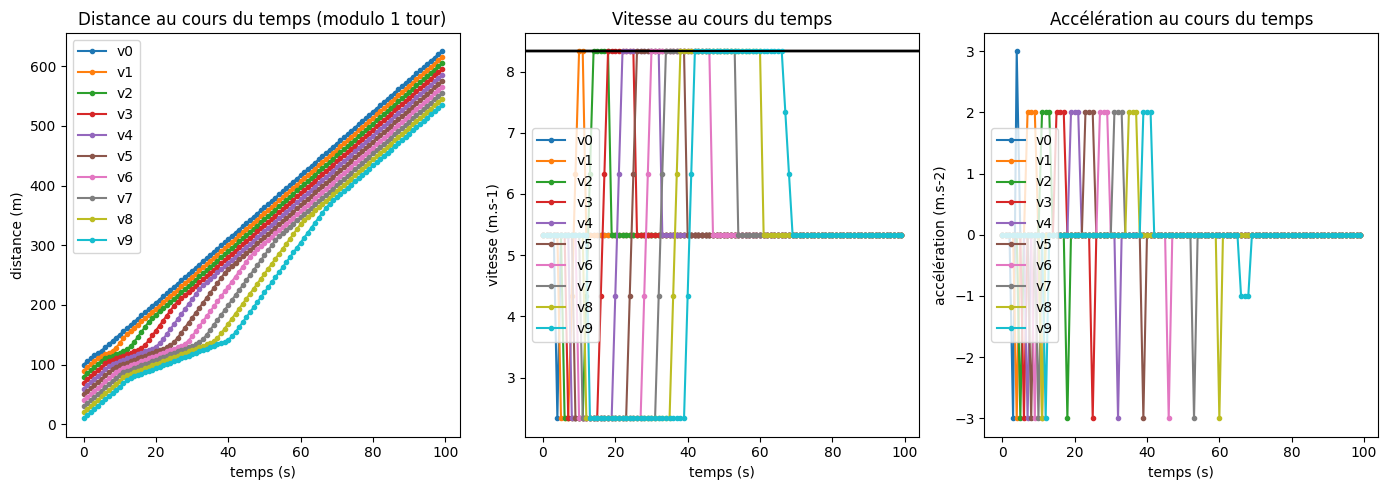

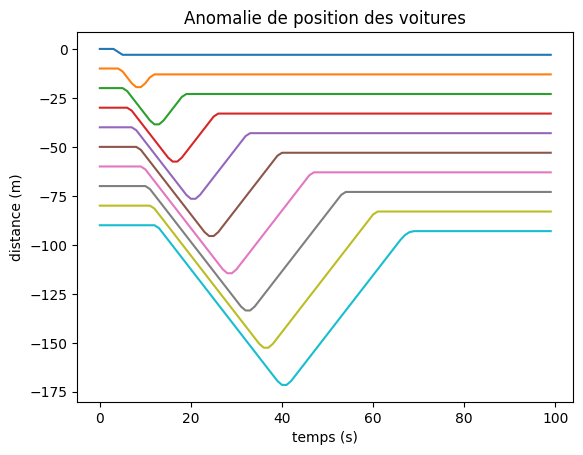

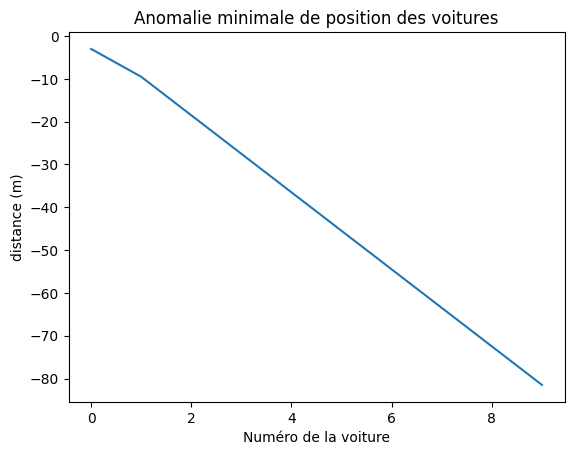

In [14]:
def algo_leadingCar(t, delta_t, vect, car_num) :
    if (t > 2 and t <= 3) :
        return -3
    elif (t > 3 and t <= 4) :
        return 3
    return 0

# On affiche la nouvelle cinématique
np_times = np.arange(0, 100, 1) # en secondes
nbCar = 10
initV = np.empty((nbCar, 2))
l_algo = [algo_leadingCar if i == 0 else algo_simpleCar for i in range(nbCar)]
for i in range(nbCar):
    initV[i, :] = [(nbCar - i)*distanceMin,maxSpeed-3]
np_carKinematics = getMultipleCarKinematics(np_times, nbCar, l_algo, initV)
showCarKinematics(np_carKinematics, trackLen, maxSpeed)

# On affiche la distance séparant les voitures
firstCarExpectedKinematic = initV[0,0] + initV[0,1]*np_times
for i in range(nbCar):
    plt.plot(np_times, np_carKinematics[i, 0, :] - firstCarExpectedKinematic)
plt.title("Anomalie de position des voitures")
plt.xlabel('temps (s)')
plt.ylabel('distance (m)')
plt.show()

# On affiche la distance séparant les voitures
minPosError = np.empty(nbCar)
for i in range(nbCar):
    minPosError[i] = min(np_carKinematics[i, 0, :] - (initV[i,0] + initV[i,1]*np_times))
plt.plot(range(nbCar), minPosError)
plt.title("Anomalie minimale de position des voitures")
plt.xlabel("Numéro de la voiture")
plt.ylabel('distance (m)')
plt.show()

On introduit maintenant le temps de réaction de l'automobiliste. Pour celà on réutilise exactement le même algorithme mais on fais passer l'ago dans une fonction intermédiare qui tronque la fin du tableau pour simuler une quantité temporellement limité d'information qui parviennent à l'automobiliste au moment de la prise de décision.

On part du principe qu'en t=0, les conditions initiales se sont vérifiées pendant déjà 1 temps de réaction. De cette manière, on peut appeler la même méthode de décision. Cependant, on ne retourne que les instants à partir de t=0

In [15]:
def getMultipleCarKinematics(l_t, nbCar, l_getCarAccel, v_ini, reacTime):
    '''
    Donne la position de la voiture à partir d'une liste d'instants (en secondes)
        - nbCar le nombre de voitures à simuler
        - l_getCarAccel donne l'accélération choisie en fonction des paramètres pour chaque voiture
        - v_ini est le vecteur d'initialisation de la position et de la vitesse de chaque voiture

    Attention, pour que l'algorithme de décision fonctionne au mieux, il faut fournir en premier la voiture de tête puis dans l'ordre décroissant de position

    retourne un tableau numpy 3D. La première dimension identifie la voiture. La seconde dimention nous donne :
        - en indice 0 le tableau des positions
        - en indice 1 le tableau des vitesses
        - en indice 2 le tableau des accélérations
    La troisième dimension est le temps.
    '''
    retVal = np.empty((nbCar, 3, reacTime + len(l_t)))
    delta_t = l_t[1] - l_t[0]
    
    # Conditions initiales
    retVal[:, 0:2, reacTime] = v_ini
    retVal[:, 2, :reacTime] = 0
    i = reacTime
    while i > 0:
        i = i-1
        retVal[:, 2, i] = 0
        retVal[:, 1, i] = v_ini[:,1]
        retVal[:, 0, i] = retVal[:, 0, i+1] - v_ini[:,1]*delta_t

    # On utilise une approche instant par instant pour que la voiture puisse réagir à la situation présentée
    for i in range(reacTime, reacTime+len(l_t)) :
        for carNum in range(nbCar) :
            # On intègre par la méthodes des rectangles à droite et des trapèzes
            if (i > reacTime) :
                # Max avec 0 pour assurer une vitesse positive ou nule
                retVal[carNum, 1, i] = max(0, retVal[carNum, 1, i-1] + retVal[carNum, 2, i-1] * delta_t) 
                retVal[carNum, 0, i] = retVal[carNum, 0, i-1] + (retVal[carNum, 1, i] + retVal[carNum, 1, i-1]) * delta_t / 2
            
            # On calcule la réaction du conducteur à ces conditions
            retVal[carNum, 2, i] = l_getCarAccel[carNum](l_t[i-reacTime], delta_t, retVal[:, :, :i+1], carNum, reacTime)
    return retVal[:,:,reacTime:]

On peut ensuite adapter les algorithmes de décision pour prendre en compte le temps de réaction. Il est intéressant de réfléchir sur la nature d'un temps de réaction. Il peut être uniquement sur la vitesse ou bien uniquement sur les données récupérées des autres voitures. 

Dans le cadre de cette simulation, je choisis de considérer que le temps de réaction impacte toutes les données mesurées

In [16]:
def algo_simpleCar(t, delta_t, vect, carNum, reacTime) :
    # Donne la vitesse de la voiture actuelle
    currentSpeed = vect[carNum, 1, -1]
    # Donne l'index de la voiture devant (pourait être amélioré en considérant la liste des positions)
    prevCarNum = carNum-1
    # Donne la distance relative avec la voiture de devant (moins la distance de sécurité)
    relDis = vect[prevCarNum, 0, -1-reacTime] - vect[carNum, 0, -1-reacTime] - distanceMin
    if (carNum == 0) :
        relDis += trackLen
    # Donne la vitesse relative avec la voiture de devant
    relSpeed = vect[prevCarNum, 1, -1-reacTime] - vect[carNum, 1, -1-reacTime]

    # On calcule le freinage voulu pour atteindre une vitesse de 0 à la distance relDis
    if (relSpeed < 0) :
        T = np.abs(2 * relDis/relSpeed) # Le temps caractéristique du freinage
        if (T < delta_t) : # Si plus petit qu'intervalle de simulation on utilise une autre formule (évite les divisions par 0 et changements infinitésimaux)
            desiredBreaking = -relSpeed / delta_t
            return -min(desiredBreaking, breakMax)
        
        desiredBreaking = np.abs((1/2) * (relSpeed**2)/relDis)
        if (desiredBreaking >= breakMin): # Si la voiture est assez proche pour tomber dans l'intervalle [breakMin, breakMax]
            return -min(desiredBreaking, breakMax)

    # S'il y a une voiture proche et qu'accélérer entraine une collision, on accélère pas
    if ((relSpeed + accelMin * delta_t) * delta_t > relDis) :
        return 0

    # Enfin, si la voie est libre, on calcule l'accélération voulue pour atteindre la vitesse cible en un intervalle de temps
    desiredAccel = min((maxSpeed - currentSpeed) / delta_t, accelMax)
    if (desiredAccel < accelMin):
        return 0
    return desiredAccel

def algo_leadingCar(t, delta_t, vect, car_num, reacTime) :
    if (t > 2 and t <= 3) :
        return -3
    elif (t > 3 and t <= 4) :
        return 3
    return 0

On répète la même expérience que précédemment. Il est intéressant de remarquer que dans ce modèle, l'amplitude de la perturbation est une fonction linéaire du nombre de voitures. L'accélération maximale étant fixée, la perturbation ne peut donc pas grandir plus que l'accélération maximale * le temps de réaction par voiture.

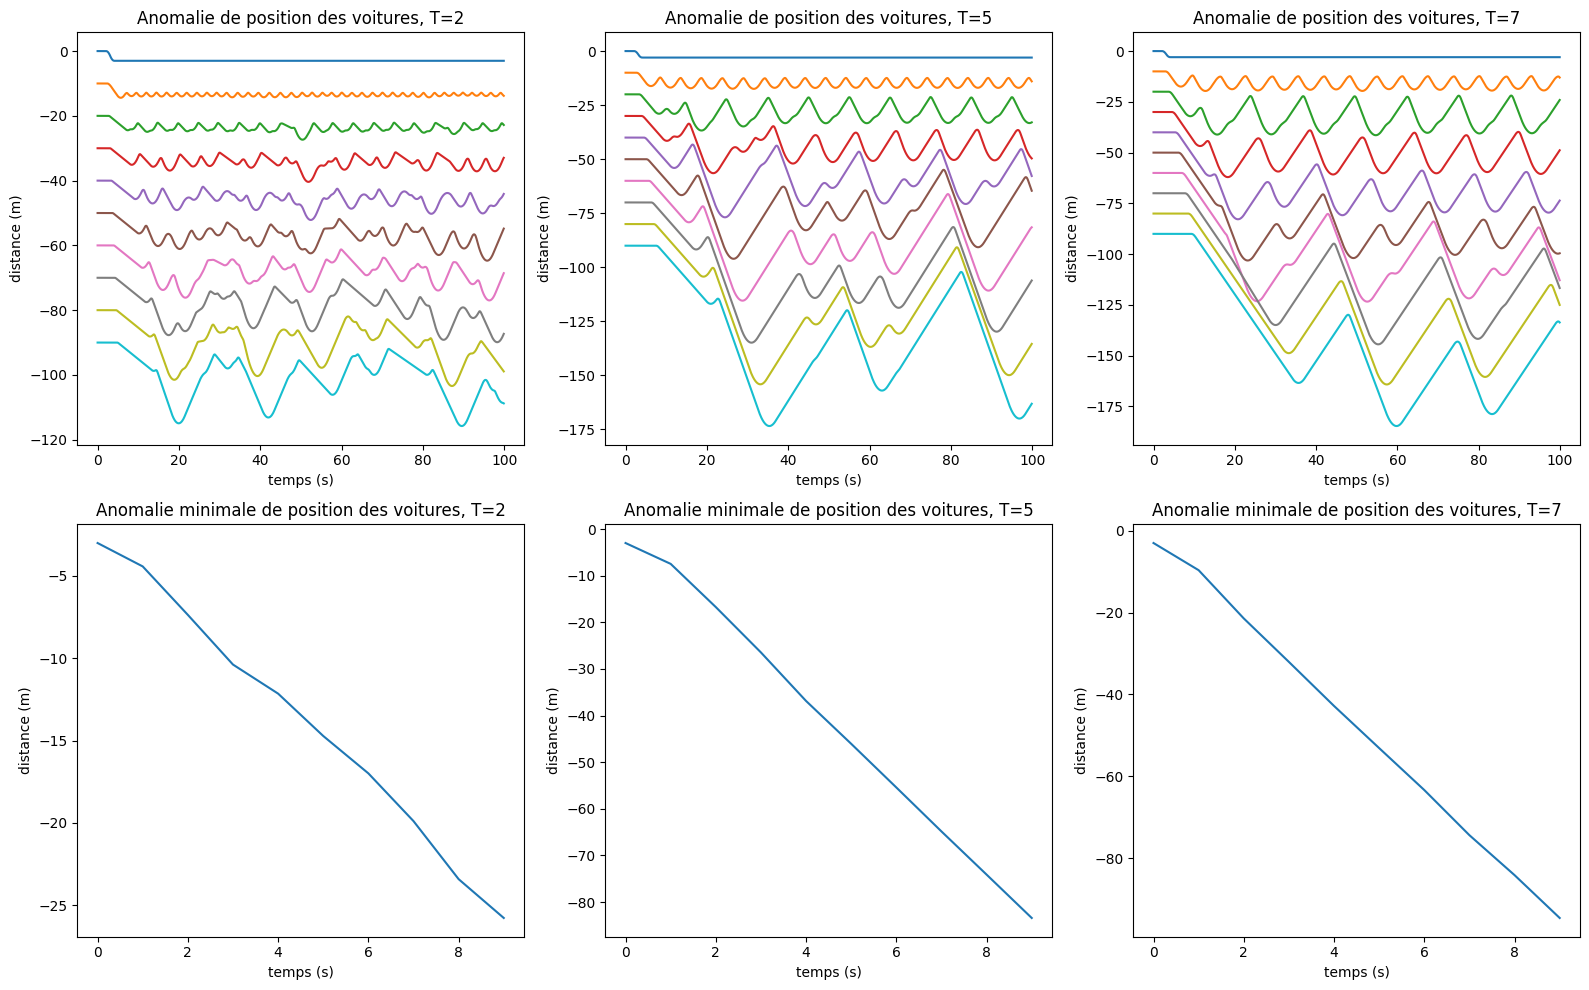

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

# On affiche la nouvelle cinématique
np_times = np.arange(0, 100, 0.1) # en secondes
nbCar = 10
reacTime = 5
initV = np.empty((nbCar, 2))
l_algo = [algo_leadingCar if i == 0 else algo_simpleCar for i in range(nbCar)]
for i in range(nbCar):
    initV[i, :] = [(nbCar - i)*distanceMin,maxSpeed-3]

np_carKinematics1 = getMultipleCarKinematics(np_times, nbCar, l_algo, initV, reacTime=2)
np_carKinematics2 = getMultipleCarKinematics(np_times, nbCar, l_algo, initV, reacTime=5)
np_carKinematics3 = getMultipleCarKinematics(np_times, nbCar, l_algo, initV, reacTime=7)

# On affiche la distance séparant les voitures
firstCarExpectedKinematic = initV[0,0] + initV[0,1]*np_times
for i in range(nbCar):
    ax[0,0].plot(np_times, np_carKinematics1[i, 0, :] - firstCarExpectedKinematic)
ax[0,0].set_title("Anomalie de position des voitures, T=2")
ax[0,0].set_xlabel('temps (s)')
ax[0,0].set_ylabel('distance (m)')

# On affiche la distance séparant les voitures
minPosError = np.empty(nbCar)
for i in range(nbCar):
    minPosError[i] = min(np_carKinematics1[i, 0, :] - (initV[i,0] + initV[i,1]*np_times))
ax[1,0].plot(range(nbCar), minPosError)
ax[1,0].set_title("Anomalie minimale de position des voitures, T=2")
ax[1,0].set_xlabel('temps (s)')
ax[1,0].set_ylabel('distance (m)')


# On affiche la distance séparant les voitures
firstCarExpectedKinematic = initV[0,0] + initV[0,1]*np_times
for i in range(nbCar):
    ax[0,1].plot(np_times, np_carKinematics2[i, 0, :] - firstCarExpectedKinematic)
ax[0,1].set_title("Anomalie de position des voitures, T=5")
ax[0,1].set_xlabel('temps (s)')
ax[0,1].set_ylabel('distance (m)')

# On affiche la distance séparant les voitures
minPosError = np.empty(nbCar)
for i in range(nbCar):
    minPosError[i] = min(np_carKinematics2[i, 0, :] - (initV[i,0] + initV[i,1]*np_times))
ax[1,1].plot(range(nbCar), minPosError)
ax[1,1].set_title("Anomalie minimale de position des voitures, T=5")
ax[1,1].set_xlabel('temps (s)')
ax[1,1].set_ylabel('distance (m)')


# On affiche la distance séparant les voitures
firstCarExpectedKinematic = initV[0,0] + initV[0,1]*np_times
for i in range(nbCar):
    ax[0,2].plot(np_times, np_carKinematics3[i, 0, :] - firstCarExpectedKinematic)
ax[0,2].set_title("Anomalie de position des voitures, T=7")
ax[0,2].set_xlabel('temps (s)')
ax[0,2].set_ylabel('distance (m)')

# On affiche la distance séparant les voitures
minPosError = np.empty(nbCar)
for i in range(nbCar):
    minPosError[i] = min(np_carKinematics3[i, 0, :] - (initV[i,0] + initV[i,1]*np_times))
ax[1,2].plot(range(nbCar), minPosError)
ax[1,2].set_title("Anomalie minimale de position des voitures, T=7")
ax[1,2].set_xlabel('temps (s)')
ax[1,2].set_ylabel('distance (m)')

plt.tight_layout(w_pad=1, h_pad=1)
plt.show()

## 5) Comparaison des modèles aux mesures expérimentales<a id='exp_id'></a>

Les 2 modèles d'accélération variable et celui d'accélération continue sont tous deux basés sur des paramètres que nous avons fixés arbitrairement. Pour se faire une idée plus précise des paramètres utilisables pour les modèles, nous avons mené une expérience pour tenter d'extraire ces paramètres de l'ajustement du modèle aux données.

### Protocole expérimental<a id='exp_protocol_id'></a>
Avec un téléphone placé à plat sur l'accoudoir central, le passager déclenche la mesure avec la voiture à l'arrêt. Ensuite, le conducteur accélère de manière normale jusqu'à une vitesse limite imposée par le limiteur de vitesse. Enfin, le conducteur doit ralentir jusqu'à l'arrêt sans dépasser la limite de distance imposée. Le passager stoppe alors la mesure et enregistre les données.

Une seconde expérience a consisté en une mesure identique, mais alors que la voiture était déjà en mouvement. Lors d'un arrêt à un feu ou lors d'un changement de limite de vitesse.

Enfin, la troisième expérience est menée sur le même circuit que la première expérience, mais en enregistrant les données GPS.

### Lecture des mesures<a id='exp_datareading_id'></a>
On affiche les données brutes d'une expérience pour voir comment les traiter.

L'expérience consiste à partir d'une position fixe, accélérer à 40 km.h-1, stabiliser la vitesse puis ralentir jusqu'à une position fixe. J'ai utilisé le limiteur de vitesse pour m'assurer de ne pas dépasser cette limite.

       Time (s)  Acceleration x (m/s^2)  Acceleration y (m/s^2)   
0      0.264811               -0.050278               -0.713472  \
1      0.266825               -0.081403               -0.735020   
2      0.268838               -0.107739               -0.730232   
3      0.270851               -0.119710               -0.739808   
4      0.272864               -0.146046               -0.732626   
...         ...                     ...                     ...   
5754  11.955947                0.162806               -0.586579   
5755  11.957958                0.227449               -0.605733   
5756  11.959970                0.251391               -0.634463   
5757  11.962010                0.248997               -0.660800   
5758  11.964050                0.229843               -0.670376   

      Acceleration z (m/s^2)  Absolute acceleration (m/s^2)  
0                   9.871593                       9.897470  
1                   9.955390                       9.982819  
2        

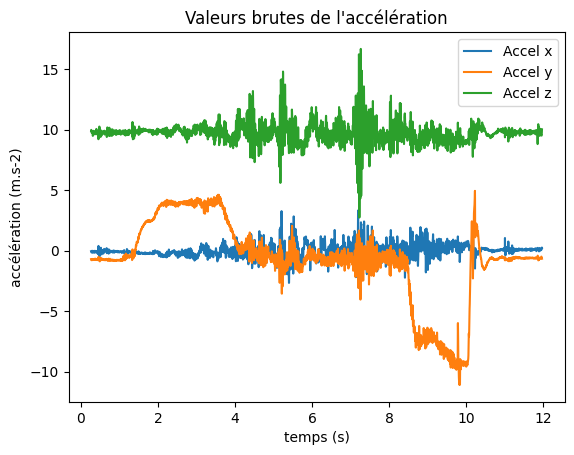

Moyenne en x -0.04
Moyenne en y -0.70
Moyenne en z 9.73


In [18]:
# Traitement des mesures
a = pd.read_csv('./RawExperiment/Acclration avec g 2024-04-22 19-32-16/Raw Data.csv')
print(a)

t = a['Time (s)']
ax = a['Acceleration x (m/s^2)']
ay = a['Acceleration y (m/s^2)']
az = a['Acceleration z (m/s^2)']

plt.plot(t, ax, label='Accel x')
plt.plot(t, ay, label='Accel y')
plt.plot(t, az, label='Accel z')
plt.title("Valeurs brutes de l'accélération")
plt.xlabel("temps (s)")
plt.ylabel("accélération (m.s-2)")
plt.legend()
plt.show()

print(f'Moyenne en x {np.mean(ax):.2f}')
print(f'Moyenne en y {np.mean(ay):.2f}')
print(f'Moyenne en z {np.mean(az):.2f}')

### Transformation des mesures et extraction de la constante g<a id='exp_transform_id'></a>

On voit que l'accélération longitudinale de la voiture est portée par le canal y de l'accéléromètre. On voit aussi que le bruit de l'accéléromètre augmente à mesure que la vitesse augmente : la voiture vibre.

On retrouve en z l'accélération de la pesanteur. Faisons la moyenne sur toutes les expériences. En comparant avec la valeur attendue pour g, on trouve un résultat proche, mais peu précis devant l'anomalie de Bouguer. C.F. [The Pan-Alpine gravity database 2020](#doc_gravityDatabase_id). Une liste non exhaustive des causes possibles de ces imprécisions sont : 
- Une erreur de calibration au lancement de l'expérience de la composante y
- Des conditions suboptimales pour la mesure de g (voiture en mouvement)
- Un défaut des capteurs de mesure (suite à quelques chutes du téléphone...)

Je distingue les 3 lots de fichiers d'expérience (telles que décrites plus haut).

In [19]:
## Expérience départ arrêté, accélération puis freinage
l_expFileNames = [
    'Acclration avec g 2024-04-22 19-29-26',
    'Acclration avec g 2024-04-22 19-29-58',
    'Acclration avec g 2024-04-22 19-30-30',
    'Acclration avec g 2024-04-22 19-31-10',
    'Acclration avec g 2024-04-22 19-31-46',
    'Acclration avec g 2024-04-22 19-32-16',
    'Acclration avec g 2024-04-22 19-35-21',
    'Acclration avec g 2024-04-22 19-35-59',
]

## Changements de vitesse en marche
l_exp2FileNames = [
    'Acclration avec g 2024-04-22 19-37-37',
    'Acclration avec g 2024-04-22 19-38-45',
    'Acclration avec g 2024-04-22 19-40-53',
    'Acclration avec g 2024-04-22 19-41-37',
    'Acclration avec g 2024-04-22 19-42-45',
    'Acclration avec g 2024-04-22 19-50-47',
    'Acclration avec g 2024-04-22 19-51-24',
    'Acclration avec g 2024-04-22 19-54-13',
    'Acclration avec g 2024-04-22 19-55-09',
    'Acclration avec g 2024-04-22 19-55-48',
    'Acclration avec g 2024-04-22 19-49-24',
    'Acclration avec g 2024-04-22 19-50-35',
]

## Mesures GPS du départ arrêté
l_exp3FileNames = [
    'Localisation GPS 2024-04-22 19-24-40',
    'Localisation GPS 2024-04-22 19-25-52',
    'Localisation GPS 2024-04-22 19-26-36',
    'Localisation GPS 2024-04-22 19-27-17',
    'Localisation GPS 2024-04-22 19-27-57',
    'Localisation GPS 2024-04-22 19-28-33',
    'Localisation GPS 2024-04-22 19-32-56',
    'Localisation GPS 2024-04-22 19-33-34',
]


_colt = 'Time (s)'
_colx = 'Acceleration x (m/s^2)'
_coly = 'Acceleration y (m/s^2)'
_colz = 'Acceleration z (m/s^2)'

# Read all CSVs 
#================================

#Start and stop
d_pd_experiment = {}
for path in l_expFileNames :
    a = pd.read_csv('./RawExperiment/' + path + '/Raw Data.csv')
    d_pd_experiment[path] = a
# L'expérience l_expFileNames[4] n'a pas été reset et contient les donnés du fichier précédent. Je les retire
l = len(d_pd_experiment[l_expFileNames[3]])
d_pd_experiment[l_expFileNames[4]] = d_pd_experiment[l_expFileNames[4]][l:]
d_pd_experiment[l_expFileNames[4]][_colt] = d_pd_experiment[l_expFileNames[4]][_colt] - d_pd_experiment[l_expFileNames[4]].iat[0, 0]

#================================

# Break and accel
d_pd_experiment2 = {}
for path in l_exp2FileNames :
    a = pd.read_csv('./RawExperiment/' + path + '/Raw Data.csv')
    d_pd_experiment2[path] = a

#================================

# GPS
d_pd_experiment3 = {}
for path in l_exp3FileNames :
    a = pd.read_csv('./RawExperiment/' + path + '/Raw Data.csv')
    d_pd_experiment3[path] = a
    
#================================

l_accelZ = []
for key, val in d_pd_experiment.items() :
    az = val[_colz]
    #print(f'Moyenne en z {np.mean(az):.2f}')
    l_accelZ.append(np.mean(az))
print(f'\nMoyenne globale en z : {np.mean(l_accelZ):.2f}')
# ref : https://dataservices.gfz-potsdam.de/panmetaworks/showshort.php?id=8039528e-3ada-11eb-9603-497c92695674
print(f'Anomalie de Bouguer à Gap environ {-87.572e-5:.1e}')
print(f'Constante g attendue : {9.806-87.572e-5:.3f}')

l_accelXYZ = []
for key, val in d_pd_experiment.items() :
    ax = val[_colx]
    ay = val[_coly]
    az = val[_colz]
    meanX = np.absolute(np.mean(ax))
    meanY = np.absolute(np.mean(ay))
    meanZ = np.absolute(np.mean(az))
    #print(f'Moyenne en somme absolue xyz {meanX + meanY + meanZ:.2f}')
    l_accelXYZ.append(meanX + meanY + meanZ)
print(f'\nMoyenne globale en somme absolue xyz : {np.mean(l_accelXYZ):.2f}')
# ref : https://dataservices.gfz-potsdam.de/panmetaworks/showshort.php?id=8039528e-3ada-11eb-9603-497c92695674
print(f'Anomalie de Bouguer à Gap environ {-87.572e-5:.1e}')
print(f'Constante g attendue : {9.806-87.572e-5:.3f}')



Moyenne globale en z : 9.76
Anomalie de Bouguer à Gap environ -8.8e-04
Constante g attendue : 9.805

Moyenne globale en somme absolue xyz : 10.41
Anomalie de Bouguer à Gap environ -8.8e-04
Constante g attendue : 9.805


On s'intéresse ici à l'accélération en y. Tentons d'extraire la vitesse à partir de l'accélération pour la première mesure. On considère $v_0 = 0$.

Pour certaines mesures, je constate qu'une erreur de calibration initiale s'est insérée au cours de la mesure. Comme on a les vitesses initiales et finales qui sont nulles, la moyenne de l'accélération devrait être nulle aussi. Je peux retirer la moyenne à toutes les mesures de l'expérience 1. Malheureusement, ce n'est pas le cas pour la seconde expérience. J'ai compensé manuellement cette calibration, mais :
- il y a plus de bruit dans les données à cause de la voiture en marche
- l'erreur de calibration est plus grande quand la voiture n'est pas à l'arrêt

Je n'utilise donc pas ces données pour le fit. Cependant, la forme globale des mesures confirme l'hypothèse de l'accélération et du freinage à accélération constante. Le tracé des vitesses est linéaire.

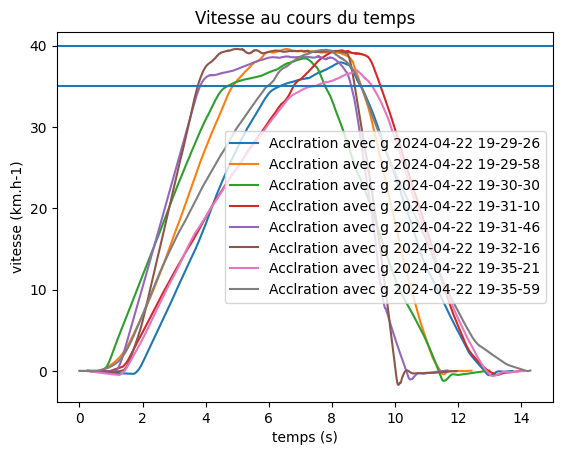

In [20]:
def integByTrapezoid(t, d):
    h = d[:-1]
    H = d[1:]
    delta = t[1:]-t[:-1]
    intg = delta*h + ((H-h)*delta)/2
    intg = np.append(intg, intg[-1])
    return np.cumsum(intg)

for key, exp in d_pd_experiment.items() :
    t = np.array(exp[_colt])
    a = np.array(exp[_coly])
    a = a - np.mean(a)
    v = integByTrapezoid(t, a)
    v = v * 3.6
    plt.plot(t, v, label=key)

plt.legend()
plt.xlabel("temps (s)")
plt.ylabel("vitesse (km.h-1)")
plt.title("Vitesse au cours du temps")
plt.axhline(y=40)
plt.axhline(y=35)
plt.show()

# L'expérience 2 est ajustée à la main mais n'est pas utilisée ici
#adjust = [0.5, 0.6, -0.15, -0.3, 0.7, 0.3, 0.8, 0.6, 0.1, 0, 0.1, 0.3]
#i = 0
#for key, exp in d_pd_experiment2.items() :
#    t = np.array(exp[_colt])
#    a = np.array(exp[_coly]) + adjust[i]
#    v = integByTrapezoid(t, a)
#    v = v * 3.6
#    plt.plot(t, a, label=key)
#    plt.title(i)
#    plt.show()
#    plt.plot(t, v, label=key)
#    plt.title(i)
#    plt.show()
#    i=i+1

Nous nous sommes intéressés à la comparaison du profil de chaque courbe. Certaines n'ont pas la phase continue, car la distance dont je dispose n'est pas assez longue pour 40km.h-1 (il aurait peut-être été mieux d'utiliser 30km.h-1). Ce sont les courbes avec l'accélération la moins forte.

Je remarque aussi que mon limiteur de vitesse s'enclenche environ 5 km.h-1 avant la vitesse cible et ralentit l'accélération avant d'atteindre les 40 km.h-1.

Les courbes qui freinent plus fort ont aussi une petite oscillation à la fin. C'est l'effet des suspensions qui oscillent juste après l'arrêt complet. Plus le freinage est fort, plus l'effet est marqué.

Tous ces effets vont influer sur l'ajustement des mesures. Si nous venions à répéter l'expérience, nous conseillions de faire attention à ces effets lors des mesures.

On peut aussi tracer la position de la voiture en fonction du temps. On constate que la distance parcourue est à peu près 70 mètres.

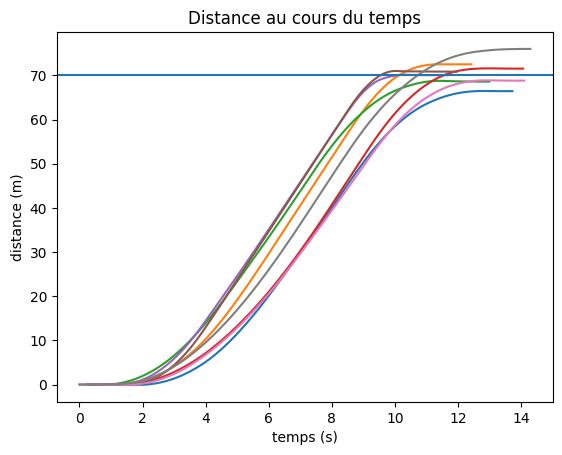

In [21]:
for key, exp in d_pd_experiment.items() :
    t = np.array(exp[_colt])
    a = np.array(exp[_coly])
    a = a - np.mean(a)
    v = integByTrapezoid(t, a)
    p = integByTrapezoid(t, v)

    plt.plot(t, p, label=key)
    
#plt.legend()
plt.xlabel("temps (s)")
plt.ylabel("distance (m)")
plt.title("Distance au cours du temps")
plt.axhline(y=70)
plt.show()

### Validation des données par mesures GPS<a id='exp_gps_id'></a>

Comparons avec les données GPS mesurées sur le même circuit. Les données GPS confirment approximativement les mêmes valeurs de vitesse et de position. La résolution temporelle est tout de même moins bonne. C'est pourquoi j'ai choisi d'utiliser l'accéléromètre.

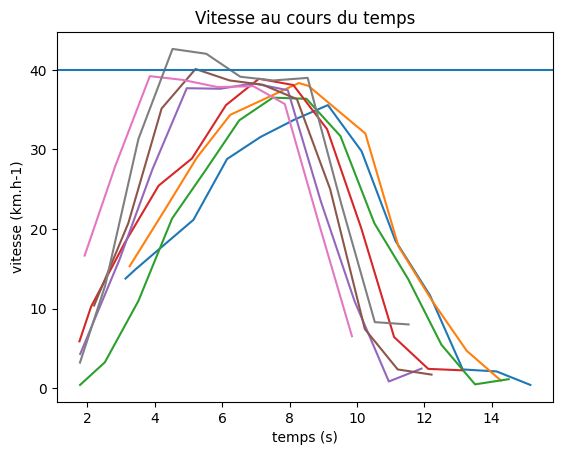

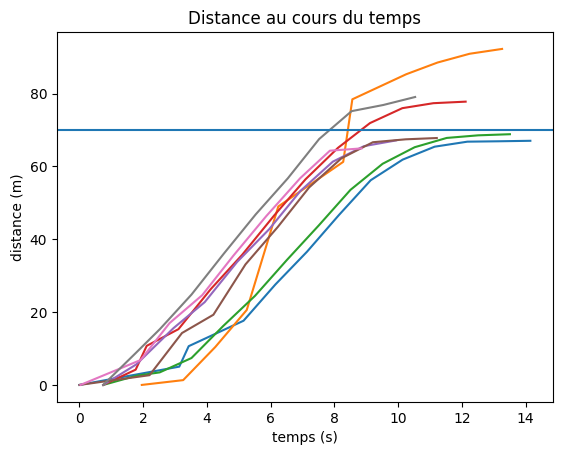

In [22]:
for key, exp in d_pd_experiment3.items() :
    t = np.array(exp['Time (s)'])
    v = np.array(exp['Speed (m/s)'])
    v = v*3.6
    plt.plot(t, v, label=key)
    
#plt.legend()
plt.xlabel("temps (s)")
plt.ylabel("vitesse (km.h-1)")
plt.title("Vitesse au cours du temps")
plt.axhline(y=40)
plt.show()

for key, exp in d_pd_experiment3.items() :
    t = np.array(exp['Time (s)'])
    p = np.array(exp['Distance (km)'])
    p = (p-p[0])*1000
    plt.plot(t, p, label=key)
    
#plt.legend()
plt.xlabel("temps (s)")
plt.ylabel("distance (m)")
plt.title("Distance au cours du temps")
plt.axhline(y=70)
plt.show()

### Fit aux modèles<a id='exp_fit_id'></a>

Je cherche maintenant à extraire les valeurs de l'accélération lors de l'accélération et du freinage. Je vais pour cela créer un modèle pour la vitesse et fit aux données.

Le modèle considère 5 phases :
- Une phase constante de vitesse nulle avant t1
- Une phase d'accélération constante a1 jusqu'à vmax
- Une phase d'accélération nulle et à vitesse vmax
- Une phase de ralentissement d'accélération -a2 jusqu'à t2
- Après t2 une phase de vitesse nulle

On prend comme conditions de validité pour le modèle :
- t1 < t2
- vmax > 0
- a1 > 0
- a2 > 0

On voit apparaître 4 temps caractéristiques. t1 et t2 sont respectivement les temps entre les phases (1,2) et (4,5). Il nous manque les temps entre (2,3) et (3,4). Avec un calcul simple sur les équations du mouvement uniformément accéléré, on obtient :
$$
t(2,3) = t_1 + \frac{v_{max}}{a_1}
$$
$$
t(3,4) = t_2 - \frac{v_{max}}{a_2}
$$

Il faut encore considérer un cas, qui est que a1 et a2 ne sont pas suffisants pour que t(2,3) < t(3,4). Dans ce cas, la droite d'accélération intercepte la droite de ralentissement en :
$$
v = a_1(t - t1) = -a_2(t - t2)
$$
$$
\Leftrightarrow t = \frac{a_1*t_1 + a_2*t_2}{a_1 + a_2}
$$

Dans ce cas, il n'y aura que 4 phases et t(2,3) == t(3,4). Ce modèle est l'équivalent du premier modèle proposé pour la modélisation du comportement de l'automobiliste.

Je fit un premier modèle à une expérience manuellement avant de fit toutes les expériences.

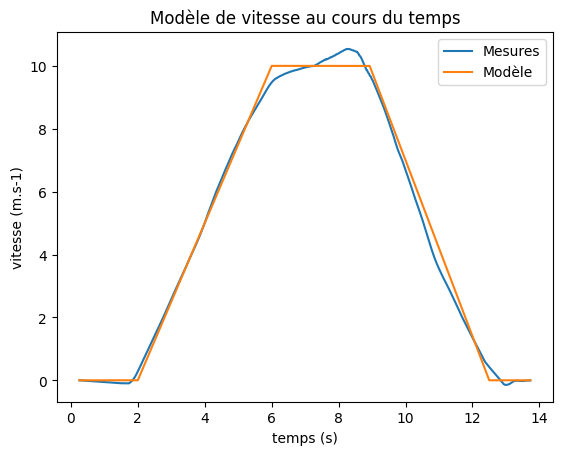

In [23]:
def modelExp1(t, a1, a2, t1, t2, vmax):
    # Les cas invalides pour la suite des calculs 
    if (t1 >= t2) or (vmax <= 0) or (a1 <= 0) or (a2 <= 0):
        return np.zeros(len(t))
    
    #Le cas général
    retval=np.zeros(len(t))
    t1end = t1 + vmax/a1
    t2begin = t2 - vmax/a2
    
    # Intersect
    if (t2begin < t1end) :
        t2begin = (a1*t1 + a2*t2)/(a1+a2)
        t1end = t2begin
    retval[t > t1] = a1*(t[t > t1] - t1)
    retval[t > t1end] = vmax
    retval[t > t2begin] = -a2*(t[t > t2begin] - t2)
    retval[t > t2] = 0
    return retval

exp = d_pd_experiment[l_expFileNames[0]]
t = np.array(exp[_colt])
a = np.array(exp[_coly])
a = a - np.mean(a)
v = integByTrapezoid(t, a)
v = v
modelData = modelExp1(t, 2.5, 2.8, 2, 12.5, 10)

plt.plot(t, v, label="Mesures")
plt.plot(t, modelData, label="Modèle")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel("vitesse (m.s-1)")
plt.title("Modèle de vitesse au cours du temps")
plt.show()

=== Solution du fit ===
a1 = 	2.4 +/-3.4e-03m.s-2
a2 = 	2.8 +/-4.3e-03m.s-2
t1 = 	1.9 +/-3.5e-03s
t2 = 	12.4 +/-3.3e-03s
vmax = 	10.1 +/-5.4e-03m.s-1
diff2 =	2.46e+02

=== Solution du fit ===
a1 = 	2.7 +/-3.2e-03m.s-2
a2 = 	4.3 +/-6.5e-03m.s-2
t1 = 	1.2 +/-2.8e-03s
t2 = 	11.2 +/-2.2e-03s
vmax = 	10.8 +/-4.1e-03m.s-1
diff2 =	1.66e+02

=== Solution du fit ===
a1 = 	2.6 +/-4.0e-03m.s-2
a2 = 	2.8 +/-4.3e-03m.s-2
t1 = 	0.8 +/-3.4e-03s
t2 = 	11.3 +/-3.3e-03s
vmax = 	10.2 +/-5.1e-03m.s-1
diff2 =	2.38e+02

=== Solution du fit ===
a1 = 	1.7 +/-1.7e-03m.s-2
a2 = 	3.3 +/-4.4e-03m.s-2
t1 = 	1.1 +/-3.5e-03s
t2 = 	12.5 +/-2.5e-03s
vmax = 	10.8 +/-5.4e-03m.s-1
diff2 =	1.90e+02

=== Solution du fit ===
a1 = 	3.8 +/-6.9e-03m.s-2
a2 = 	6.6 +/-1.6e-02m.s-2
t1 = 	1.2 +/-3.0e-03s
t2 = 	10.1 +/-2.2e-03s
vmax = 	10.5 +/-4.4e-03m.s-1
diff2 =	2.49e+02

=== Solution du fit ===
a1 = 	4.4 +/-5.1e-03m.s-2
a2 = 	7.4 +/-1.1e-02m.s-2
t1 = 	1.6 +/-1.6e-03s
t2 = 	10.1 +/-1.3e-03s
vmax = 	10.9 +/-2.6e-03m.s-1
diff2 =	9.

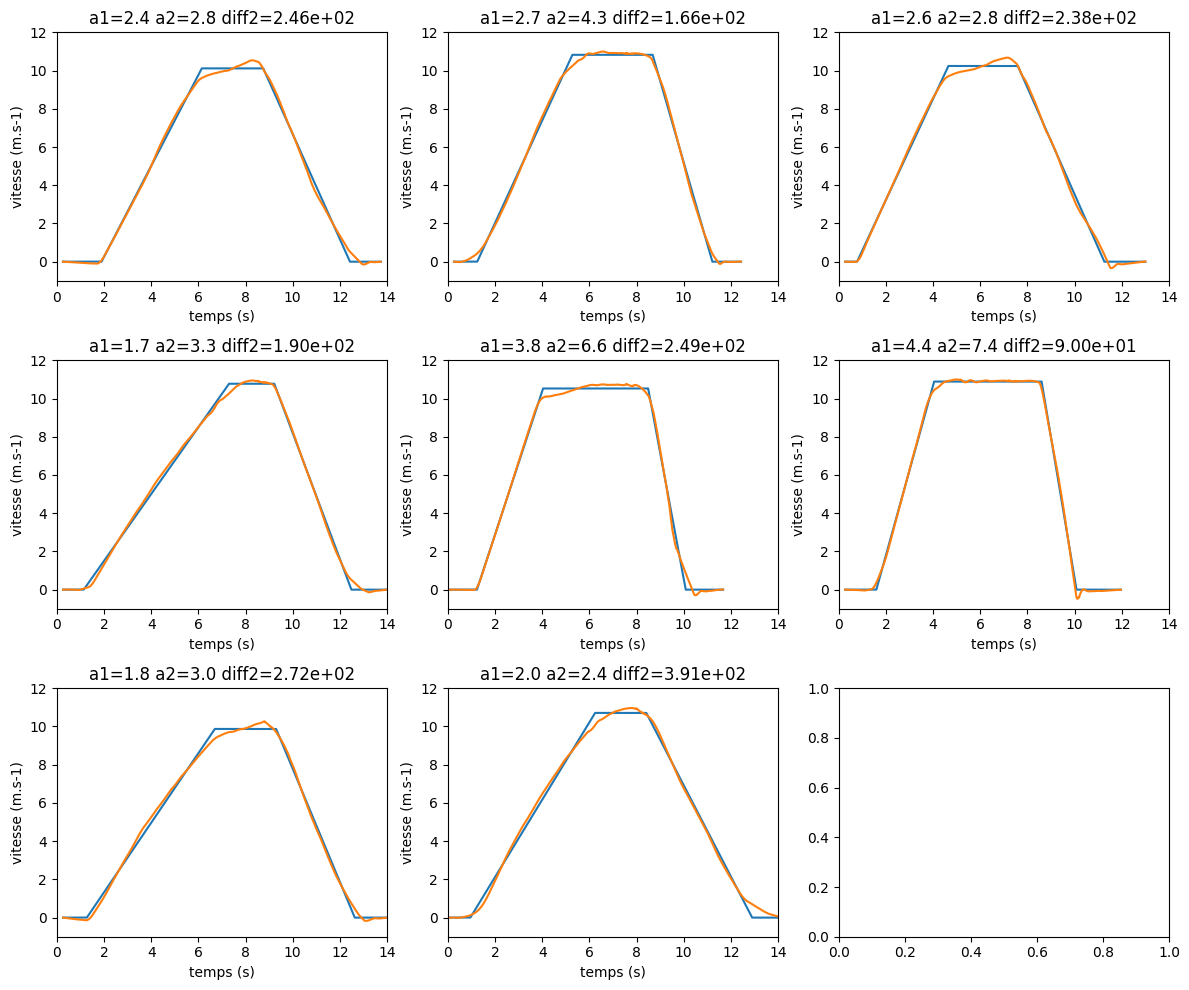

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10)) 

i = 0
for key, exp in d_pd_experiment.items() :
    t = np.array(exp[_colt])
    a = np.array(exp[_coly])
    a = a - np.mean(a)
    v = integByTrapezoid(t, a)
    solution, pcov = curve_fit(modelExp1, t, v, p0=[2.5, 2.8, 2, 12.5, 10])
    a1 = solution[0]
    a2 = solution[1]
    t1 = solution[2]
    t2 = solution[3]
    vmax = solution[4]
    
    perr = np.sqrt(np.diag(pcov))
    modelData = modelExp1(t, a1, a2, t1, t2, vmax)
    diff_quadra = np.sum(np.absolute(modelData - v)**2)
    print(f"=== Solution du fit ===")
    print(f"a1 = \t{a1:.1f} +/-{perr[0]:.1e}m.s-2")
    print(f"a2 = \t{a2:.1f} +/-{perr[1]:.1e}m.s-2")
    print(f"t1 = \t{t1:.1f} +/-{perr[2]:.1e}s")
    print(f"t2 = \t{t2:.1f} +/-{perr[3]:.1e}s")
    print(f"vmax = \t{vmax:.1f} +/-{perr[4]:.1e}m.s-1")
    print(f"diff2 =\t{diff_quadra:.2e}")
    print(f"=======================\n")
    
    ax = axs[int(i/3), i%3]
    ax.plot(t, modelData)
    ax.plot(t, v)
    ax.set_xlabel("temps (s)")
    ax.set_ylabel("vitesse (m.s-1)")
    ax.set_title(f"a1={a1:.1f} a2={a2:.1f} diff2={diff_quadra:.2e}")
    ax.set_xlim(0, 14)
    ax.set_ylim(-1, 12)
    i=i+1

plt.tight_layout(w_pad=1, h_pad=1)
plt.show()

Il est intéressant de comparer la précision du fit avec l'autre modèle.

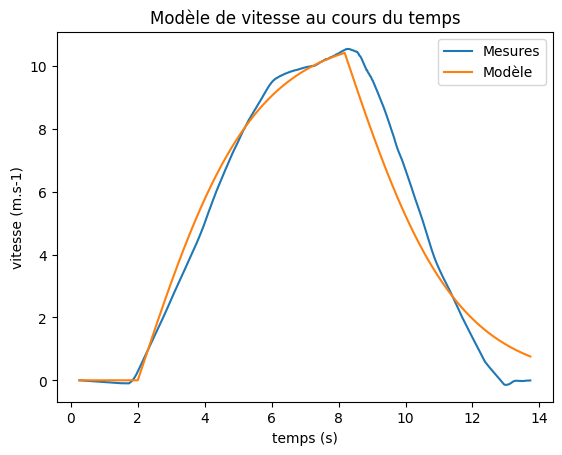

In [25]:
def getCarKinematics(l_t, a1, a2, t1, t2, vmax):
    # Les cas invalides pour la suite des calculs 
    if (t1 >= t2) or (vmax <= 0) or (a1 <= 0) or (a2 <= 0):
        return np.zeros(len(l_t))
    
    #Le cas général
    retval=np.zeros(len(l_t))
    retval[l_t > t1] = vmax*np.tanh(a1/vmax * (l_t[l_t > t1] - t1))
    phase2 = vmax*(1-np.tanh(a2/vmax * (l_t - t2)))
    diff = np.absolute(retval - phase2)
    intersect = l_t[np.argmin(diff)]
    retval[l_t > intersect] = vmax*(1-np.tanh(a2/vmax * (l_t[l_t > intersect] - t2)))
    return retval

exp = d_pd_experiment[l_expFileNames[0]]
t = np.array(exp[_colt])
a = np.array(exp[_coly])
a = a - np.mean(a)
v = integByTrapezoid(t, a)
v = v
modelData = getCarKinematics(t, 3.2, 3.2, 2, 8, 11)

plt.plot(t, v, label="Mesures")
plt.plot(t, modelData, label="Modèle")
plt.legend()
plt.xlabel("temps (s)")
plt.ylabel("vitesse (m.s-1)")
plt.title("Modèle de vitesse au cours du temps")
plt.show()

=== Solution du fit ===
a1 = 	3.3 +/-1.4e-02m.s-2
a2 = 	4.6 +/-1.7e-02m.s-2
t1 = 	2.2 +/-6.1e-03s
t2 = 	8.9 +/-6.4e-03s
vmax = 	11.0 +/-2.1e-02m.s-1
diff2 =	8.90e+02

=== Solution du fit ===
a1 = 	4.0 +/-2.0e-02m.s-2
a2 = 	7.0 +/-3.7e-02m.s-2
t1 = 	1.6 +/-6.6e-03s
t2 = 	8.9 +/-5.2e-03s
vmax = 	11.3 +/-1.8e-02m.s-1
diff2 =	1.27e+03

=== Solution du fit ===
a1 = 	3.8 +/-1.8e-02m.s-2
a2 = 	4.7 +/-2.0e-02m.s-2
t1 = 	1.1 +/-6.4e-03s
t2 = 	7.8 +/-6.5e-03s
vmax = 	10.9 +/-1.9e-02m.s-1
diff2 =	1.11e+03

=== Solution du fit ===
a1 = 	2.3 +/-9.4e-03m.s-2
a2 = 	5.7 +/-2.5e-02m.s-2
t1 = 	1.5 +/-8.0e-03s
t2 = 	9.2 +/-7.8e-03s
vmax = 	12.5 +/-3.9e-02m.s-1
diff2 =	1.04e+03

=== Solution du fit ===
a1 = 	5.6 +/-2.2e-02m.s-2
a2 = 	11.0 +/-5.5e-02m.s-2
t1 = 	1.5 +/-4.0e-03s
t2 = 	8.6 +/-2.9e-03s
vmax = 	10.8 +/-9.2e-03m.s-1
diff2 =	6.64e+02

=== Solution du fit ===
a1 = 	7.0 +/-4.0e-02m.s-2
a2 = 	11.9 +/-8.1e-02m.s-2
t1 = 	1.8 +/-4.8e-03s
t2 = 	8.7 +/-3.6e-03s
vmax = 	11.1 +/-1.1e-02m.s-1
diff2 =	1.22e+

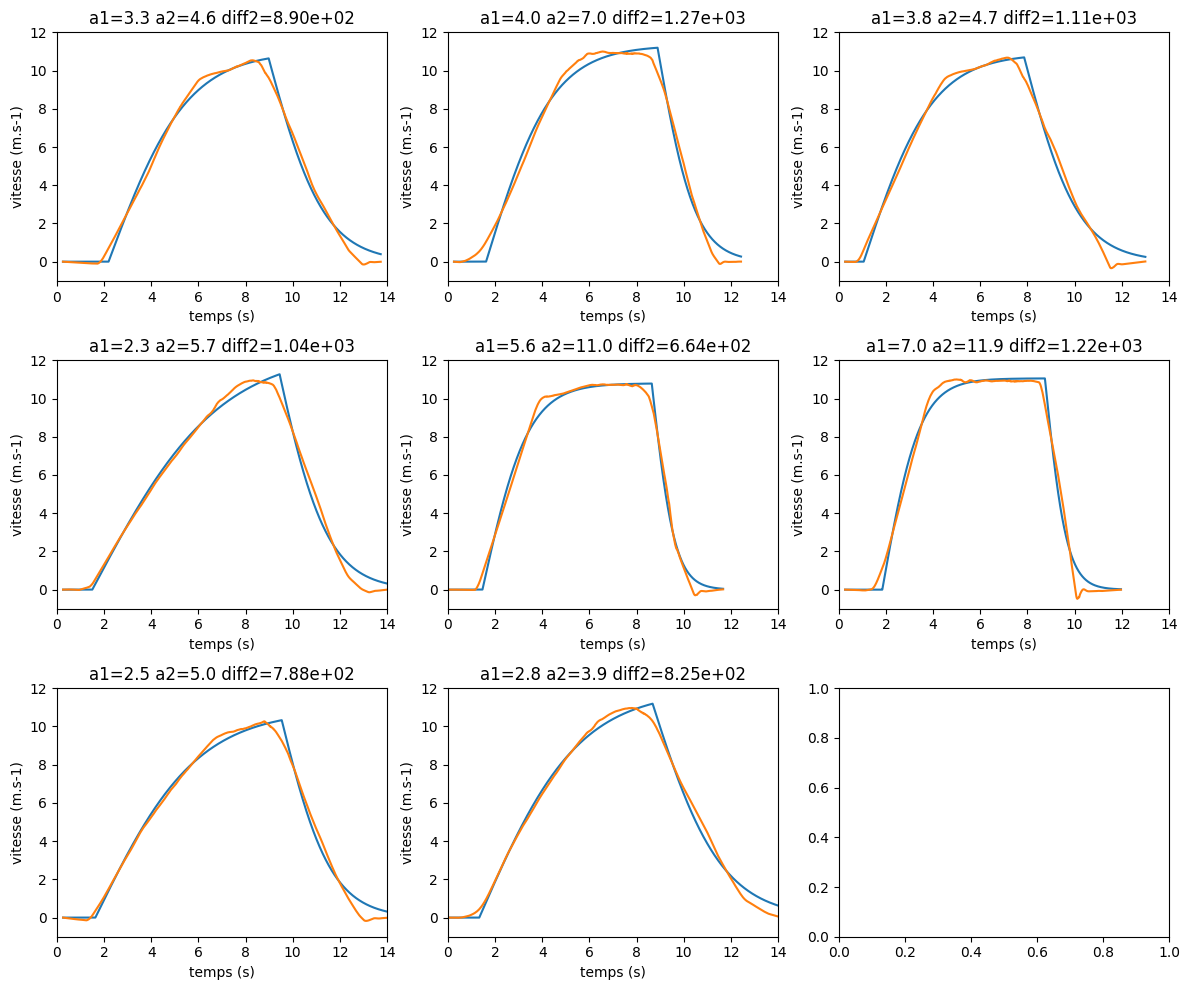

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10)) 

i = 0
for key, exp in d_pd_experiment.items() :
    t = np.array(exp[_colt])
    a = np.array(exp[_coly])
    a = a - np.mean(a)
    v = integByTrapezoid(t, a)
    solution, pcov = curve_fit(getCarKinematics, t, v, p0=[3.2, 3.2, 2, 8, 11])
    a1 = solution[0]
    a2 = solution[1]
    t1 = solution[2]
    t2 = solution[3]
    vmax = solution[4]
    
    perr = np.sqrt(np.diag(pcov))
    modelData = getCarKinematics(t, a1, a2, t1, t2, vmax)
    diff_quadra = np.sum(np.absolute(modelData - v)**2)
    print(f"=== Solution du fit ===")
    print(f"a1 = \t{a1:.1f} +/-{perr[0]:.1e}m.s-2")
    print(f"a2 = \t{a2:.1f} +/-{perr[1]:.1e}m.s-2")
    print(f"t1 = \t{t1:.1f} +/-{perr[2]:.1e}s")
    print(f"t2 = \t{t2:.1f} +/-{perr[3]:.1e}s")
    print(f"vmax = \t{vmax:.1f} +/-{perr[4]:.1e}m.s-1")
    print(f"diff2 =\t{diff_quadra:.2e}")
    print(f"=======================\n")
    
    ax = axs[int(i/3), i%3]
    ax.plot(t, modelData)
    ax.plot(t, v)
    ax.set_xlabel("temps (s)")
    ax.set_ylabel("vitesse (m.s-1)")
    ax.set_title(f"a1={a1:.1f} a2={a2:.1f} diff2={diff_quadra:.2e}")
    ax.set_xlim(0, 14)
    ax.set_ylim(-1, 12)
    i=i+1

plt.tight_layout(w_pad=1, h_pad=1)
plt.show()

### Comparaison des fit et extraction des paramètres<a id='exp_fitAnalysis_id'></a>

On a une différence quadratique qui est environ 10 fois supérieure comparé au précédent modèle. On peut donc comparer ces 2 modèles aux données et dire que le premier modèle est plus à même de modéliser et prédire ces données.

En conclusion, pour le comportement mesuré, le premier modèle faisant état d'une accélération et d'un freinage constant est plus adapté. On a aussi pu extraire les valeurs d'accélération et de freinage cohérentes qui se situent :
- Pour l'accélération, entre 1.7 et 4.4
- Pour le freinage, entre 2.4 et 7.4

Dans les cas du modèle à accélération variable, on obtient :
- Pour a1, entre 2.3 et 7.0
- Pour a2, entre 4.6 et 11.9

## Etude d'émergence d'embouteillage<a id='traficEmergence_id'></a>

On souhaite reproduire numériquement l'expérience présentée dans : [Le meilleur du Monde de Jamy - Comment se forment les bouchons ?](#doc_emergence_id). L'idée est de mesurer l'émergence de l'embouteillage en fonction des paramètres de simulation. Nous faisons la distinction entre 2 types de paramètres. Les paramètres de la route et les paramètres de comportement de l'usager de la route.

In [27]:
# ==== Paramètres de la route ====
trackLen = 1000 #Longueur de la route [m]
nbCar = 30 #nombre de voitures sur la route
maxSpeed = 100/3.6 #Vitese maximale [m.s-1]
distanceBetweenCars = trackLen / nbCar #Distance initiale entre les voitures [m]
L = 6  #Longueur d'une voiture [m]
rho_max = trackLen / L
rho_star = 1/(L*np.exp(1)) #Densité optimale [voiture/m]

# ==== Paramètres du conducteur ====
reacTime = 10 # Temps de réaction en nombre d'unité de simulation [sans unité]
rho_crit = rho_star*2/3 #Densité critique [voiture/m]
c = 4

# ==== Paramètres de la voiture ====
accelMin = 1.7 #m.s-2
accelMax = 4.4 #m.s-2
breakMin = 2.4 #m.s-2
breakMax = 7.4 #m.s-2

# Caractéristiques du conducteur
distanceMin = 10 #m

On utilise ici une variation du modèle d'accélération variable. Ce modèle a comme avantage de fournir une distance d'équilibre pour une densité donnée. Cela à pour effet de garantir une distance temporelle entre les voitures. A l'inverse, le modèle d'accélération continue aurait pour effet d'accélérer progressivement jusqu'à la vitesse maximale alors qu'on est très proche de la voiture de devant.

La variation consiste à ajouter un facteur d'accélération jusqu'à cette vitesse d'équilibre pour la densité mesurée avec la voiture de devant. Le modèle initial ne prévoyait que la force de freinage et toutes les voitures s'arrêtent après la perturbation.

In [28]:
# ==== Voiture classique ====
def algo_variableAccelCar(t, delta_t, vect, carNum, reacTime) :
    # Donne la vitesse de la voiture actuelle
    currentSpeed = vect[carNum, 1, -1]
    # Donne l'index de la voiture devant (pourait être amélioré en considérant la liste des positions)
    prevCarNum = carNum-1
    # Donne la distance relative avec la voiture de devant
    relDis = vect[prevCarNum, 0, -1-reacTime] - vect[carNum, 0, -1-reacTime] - L
    if (carNum == 0) :
        relDis += trackLen
    # Donne la vitesse relative avec la voiture de devant
    relSpeed = vect[prevCarNum, 1, -1-reacTime] - vect[carNum, 1, -1-reacTime]

    # Dans le cas d'un crash, on ralentis jusqu'à revenir derrière la voiture précédente
    if (relDis <= 0) : 
        return -breakMax

    # Dans le cas d'une vitesse relative négative, on considère le modèle initial
    elif (relSpeed < -0.01) :
        return max(c * (relSpeed)/np.absolute(relDis), -accelMax)
    
    # Sinon on estime la densité et la vitesse d'équilibre et on tente de se rapprocher de cette valeur.
    else :
        rho = 1/relDis
        v = min(maxSpeed, np.log(rho_max/rho) * maxSpeed * 1/(np.log(rho_max/rho_crit)))
        desiredAccel = min((v - currentSpeed) / delta_t, accelMax)
        if (desiredAccel < accelMin):
            #if (carNum == 0) : print(f"[{t:.1f}] CASE 3 bis")
            return 0
        #if (carNum == 0) : print(f"[{t:.1f}] CASE 3")
        return desiredAccel
    
# # Autre algorithme avec des caractéristiques similaires mais moins amorti
# def algo_variableAccelCarBis(t, delta_t, vect, carNum, reacTime) :
#     # Donne la vitesse de la voiture actuelle
#     currentSpeed = vect[carNum, 1, -1]
#     # Donne l'index de la voiture devant (pourait être amélioré en considérant la liste des positions)
#     prevCarNum = carNum-1
#     # Donne la distance relative avec la voiture de devant
#     relDis = vect[prevCarNum, 0, -1-reacTime] - vect[carNum, 0, -1-reacTime] - L
#     if (carNum == 0) :
#         relDis += trackLen
#     # Donne la vitesse relative avec la voiture de devant
#     relSpeed = vect[prevCarNum, 1, -1-reacTime] - vect[carNum, 1, -1-reacTime]
#     accelPart = accelMax * (1 - currentSpeed**2/maxSpeed**2)
#     breakPart = -c * relSpeed / np.abs(relDis)
#     if (relSpeed > 0) :
#         breakPart = 0
#     breakPart = -min(breakPart, breakMax)
#     behaviourFactor = np.tanh(relDis - 10)
#     return 0.5*((1-behaviourFactor)*breakPart + (1+behaviourFactor)*accelPart)

# ==== Preturbation ====
def algo_leadingCar(t, delta_t, vect, car_num, reacTime) :
    if (t > 10 and t <= 11) :
        return -3
    else :
        return algo_variableAccelCar(t, delta_t, vect, car_num, reacTime)

### Etude de l'impact des paramètres de la route<a id='traficEmergence_roadParametters_id'></a>

On commence par écrire une fonction qui nous donne les paramètres d'initialisation en fonction des paramètres de simulation :

In [29]:
def getVIni() :
    distanceBetweenCars = trackLen / nbCar #Distance initiale entre les voitures [m]
    initV = np.empty((nbCar, 2))
    l_algo = [algo_leadingCar if i == 0 else algo_variableAccelCar for i in range(nbCar)]
    rho_eq = 1/(distanceBetweenCars-L)
    v_eq = min(maxSpeed, np.log(rho_max/rho_eq) * maxSpeed * 1/(np.log(rho_max/rho_crit)))
    for cnum in range(nbCar):
        initV[cnum, :] = [distanceBetweenCars * (nbCar - cnum - 1),v_eq]
    return (initV, l_algo)

On peut maintenant lancer 2 simulations avec des nombres de voitures très proches du seuil critique. On voit bien qu'une toute petite variation de condition initiales donne des résultats très différents. Dans le premier cas, la perturbation est absorbée et le système reprend son équilibre. Avec une seule voiture de plus, on a une oscillation qui se met en place avec arrêt complet des voitures dans un embouteillage.

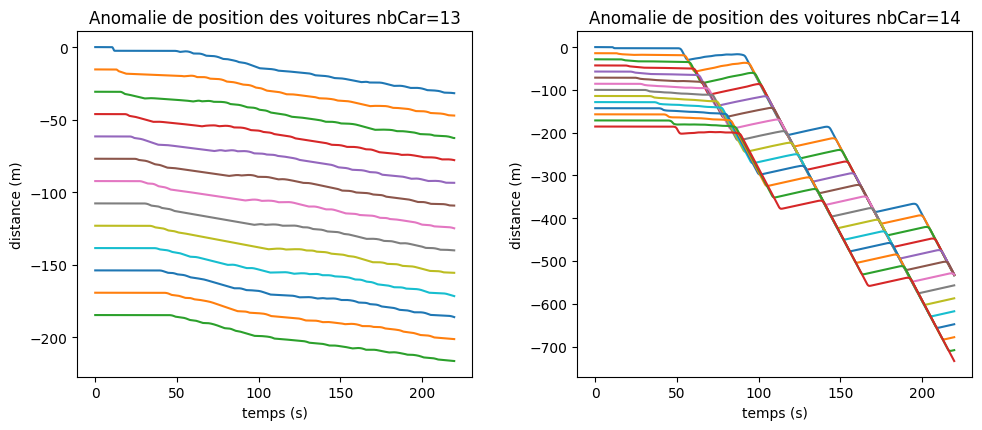

In [30]:
maxSpeed = 30/3.6 #Vitese maximale [m.s-1]
trackLen = 200 #Longueur de la route [m]
np_times = np.arange(0, 220, 0.2) # en secondes

fig, ax = plt.subplots(nrows=1, ncols=2)
nbCar = 13 #nombre de voitures sur la route
(initV, l_algo) = getVIni()
np_carKinematics = getMultipleCarKinematics(np_times, nbCar, l_algo, initV, reacTime)
expectedFirstCarKinematics = initV[0, 0] + initV[0, 1]*np_times
for cnum in range(nbCar):
    ax[0].plot(np_times, np_carKinematics[cnum,0,:] - expectedFirstCarKinematics)
ax[0].set_title(f"Anomalie de position des voitures nbCar={nbCar}")
ax[0].set_xlabel('temps (s)')
ax[0].set_ylabel('distance (m)')

nbCar = 14 #nombre de voitures sur la route
(initV, l_algo) = getVIni()
np_carKinematics = getMultipleCarKinematics(np_times, nbCar, l_algo, initV, reacTime)
expectedFirstCarKinematics = initV[0, 0] + initV[0, 1]*np_times
for cnum in range(nbCar):
    ax[1].plot(np_times, np_carKinematics[cnum,0,:] - expectedFirstCarKinematics)
ax[1].set_title(f"Anomalie de position des voitures nbCar={nbCar}")
ax[1].set_xlabel('temps (s)')
ax[1].set_ylabel('distance (m)')
fig.tight_layout(pad=0)
fig.set_figwidth(10)
fig.set_figheight(4)
plt.show()


On cherche à étudier la sévérité de l'embouteillage en fonction des paramètres de simulation. Pour ce faire, nous faisons varier le nombre de voitures et la vitesse maximale et exécutons la simulation sur chaque couple de valeur. Le résultat est une carte de niveaux que l'on peut afficher en pourcentage de la vitesse d'équilibre ou en pourcentage de la vitesse maximale.

On voit une délimitation claire entre 2 zones. Une zone où la perturbation ralentit peu le trafic et une zone où le trafic est fortement perturbé. Le seuil de stabilité de l'équilibre est surtout fonction de la densité et peu de la vitesse maximale quand on garde les paramètres du conducteur fixes.

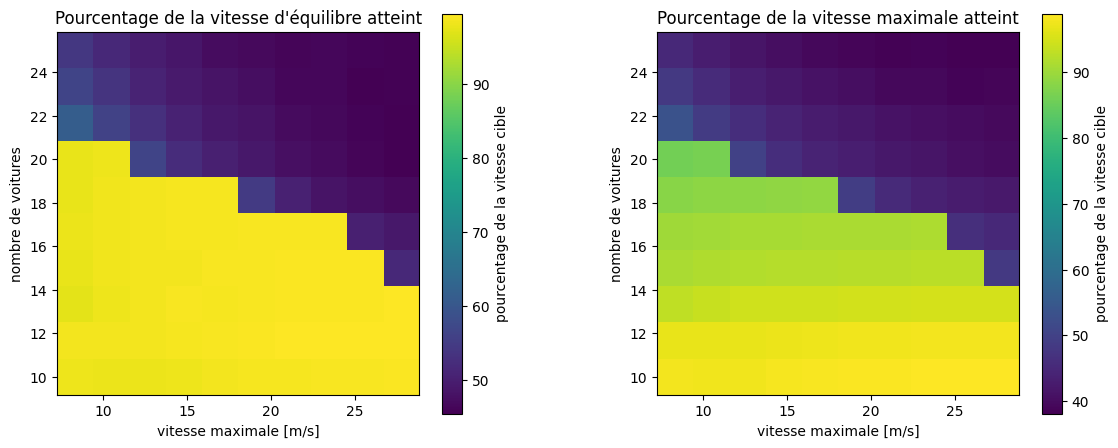

In [31]:
# ==== Modélisation ====
trackLen = 300 #Longueur de la route [m]
np_times = np.arange(0, 500, 0.2) # en secondes
range_nbCar = np.linspace(10, trackLen/(2*L), 10)
range_maxSpeed = np.linspace(30/3.6, 100/3.6, 10)
meanSpeedResult = np.empty((len(range_nbCar), len(range_maxSpeed)))
meanSpeedEqResult = np.empty((len(range_nbCar), len(range_maxSpeed)))
for (i,nbCar) in enumerate(range_nbCar):
    for (j,maxSpeed) in enumerate(range_maxSpeed):
        nbCar = int(np.floor(nbCar))
        (initV, l_algo) = getVIni()
        np_carKinematics = getMultipleCarKinematics(np_times, nbCar, l_algo, initV, reacTime)
        meanSpeed = np.mean(np_carKinematics[1:,1,:])
        meanSpeedResult[len(range_nbCar)-i-1,j] = meanSpeed * 100 / maxSpeed
        meanSpeedEqResult[len(range_nbCar)-i-1,j] = meanSpeed * 100 / initV[0,1]

# Ajustements propres aux imshow
## Pour que l'image soit carrée
aspect = (range_maxSpeed[-1]-range_maxSpeed[0])/(range_nbCar[-1]-range_nbCar[0])
## Pour que les valeurs soient allignées au millieu du bin
adjust_x = (range_maxSpeed[1] - range_maxSpeed[0])/2
adjust_y = (range_nbCar[1] - range_nbCar[0])/2
extent=[range_maxSpeed[0] - adjust_x, range_maxSpeed[-1] + adjust_x, range_nbCar[0] - adjust_y, range_nbCar[-1] + adjust_y]

# Plots
fig, ax = plt.subplots(nrows=1, ncols=2)
img = ax[0].imshow(meanSpeedEqResult, extent=extent, aspect=aspect)
plt.colorbar(img, label="pourcentage de la vitesse cible")
ax[0].set_title('Pourcentage de la vitesse d\'équilibre atteint')
ax[0].set_xlabel('vitesse maximale [m/s]')
ax[0].set_ylabel('nombre de voitures')

img = ax[1].imshow(meanSpeedResult, extent=extent, aspect=aspect)
plt.colorbar(img, label="pourcentage de la vitesse cible")
ax[1].set_title('Pourcentage de la vitesse maximale atteint')
ax[1].set_xlabel('vitesse maximale [m/s]')
ax[1].set_ylabel('nombre de voitures')

fig.tight_layout(pad=0)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.show()

### Etude de l'impact des paramètres du comportement de l'automobiliste<a id='traficEmergence_driverParametters_id'></a>

On s'intéresse maintenant à l'importance des paramètres du comportement de l'automobiliste dans des conditions de circulation identiques. On voit a nouveau 2 zones très marquées et délimitées par une fonction dépendante du temps de réaction et du facteur de conduite (plus C est grand plus la conduite est agressive). J'affiche cette fois uniquement le pourcentage de la vitesse d'équilibre. Comme la vitesse d'équilibre et maximale sont constantes sur l'espace parcouru, il n'y a pas de différence entre les 2. En revanche, j'affiche les valeurs pour 2 vitesses limites distinctes. On retrouve à nouveau les 2 zones avec et sans embouteillage. Le seuil de stabilité de l'équilibre est ici fonction des 2 paramètres comportementaux. On retrouve le résultat de l'intuition commune : plus le temps de réaction est grand et plus l'agressivité est grande plus le comportement est congestiogène.

La fonction qui donne le seuil de stabilité est aussi impactée par la limite de vitesse. On obtient des domaines de stabilité différents. En particulier, l'agressivité est moins impactante aux faibles vitesses. La limite entre les 2 domaines est aussi moins franche.

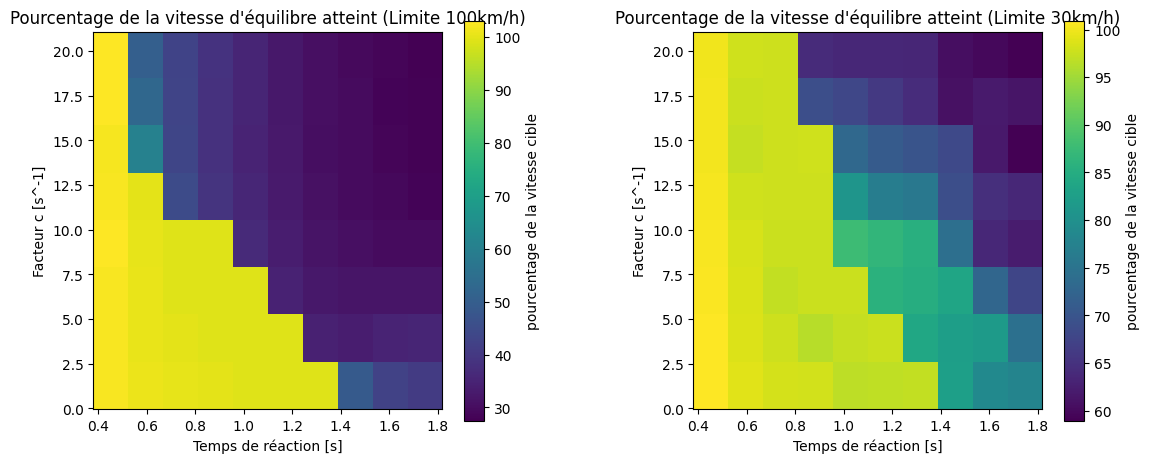

In [32]:
# ==== Paramètres de la route ====
trackLen = 200 #Longueur de la route [m]
nbCar = 12 #nombre de voitures sur la route
maxSpeed = 100/3.6 #Vitese maximale [m.s-1]
distanceBetweenCars = trackLen / nbCar #Distance initiale entre les voitures [m]
L = 6  #Longueur d'une voiture [m]
rho_max = trackLen / L
rho_star = 1/(L*np.exp(1)) #Densité optimale [voiture/m]

# ==== Paramètres du conducteur ====
reacTime = 10 # Temps de réaction en nombre d'unité de simulation [sans unité]
rho_crit = rho_star*2/3 #Densité critique [voiture/m]
c = 4

# ==== Simulation à 100km/h ==== #
np_times = np.arange(0, 500, 0.2) # en secondes
range_reacTime = np.arange(2, 10, 1)
range_c = np.linspace(1, 20, 10)
meanSpeedResult = np.empty((len(range_reacTime), len(range_c)))
(initV, l_algo) = getVIni()
for (i,reacTime) in enumerate(range_reacTime):
    for (j,c) in enumerate(range_c):
        np_carKinematics = getMultipleCarKinematics(np_times, nbCar, l_algo, initV, reacTime)
        meanSpeed = np.mean(np_carKinematics[1:,1,:])
        meanSpeedResult[len(range_reacTime)-i-1,j] = meanSpeed * 100 / initV[0,1]

# ==== Simulation à 30km/h ==== #
maxSpeed = 30/3.6 #Vitese maximale [m.s-1]
meanSpeedResult2 = np.empty((len(range_reacTime), len(range_c)))
(initV, l_algo) = getVIni()
for (i,reacTime) in enumerate(range_reacTime):
    for (j,c) in enumerate(range_c):
        np_carKinematics = getMultipleCarKinematics(np_times, nbCar, l_algo, initV, reacTime)
        meanSpeed = np.mean(np_carKinematics[1:,1,:])
        meanSpeedResult2[len(range_reacTime)-i-1,j] = meanSpeed * 100 / initV[0,1]

# Ajustements propres aux imshow
## Pour que l'image soit carrée
aspect = (range_reacTime[-1]-range_reacTime[0])*0.2/(range_c[-1]-range_c[0])
## Pour que les valeurs soient allignées au millieu du bin
adjust_x = (range_reacTime[1] - range_reacTime[0])*0.2/2
adjust_y = (range_c[1] - range_c[0])/2
extent=[(range_reacTime[0] - adjust_x)*0.2, (range_reacTime[-1] + adjust_x)*0.2, range_c[0] - adjust_y, range_c[-1] + adjust_y]

# Plots
fig, ax = plt.subplots(nrows=1, ncols=2)
img = ax[0].imshow(meanSpeedResult, extent=extent, aspect=aspect)
plt.colorbar(img, label="pourcentage de la vitesse cible")
ax[0].set_title(f'Pourcentage de la vitesse d\'équilibre atteint (Limite 100km/h)')
ax[0].set_xlabel('Temps de réaction [s]')
ax[0].set_ylabel('Facteur c [s^-1]')

img = ax[1].imshow(meanSpeedResult2, extent=extent, aspect=aspect)
plt.colorbar(img, label="pourcentage de la vitesse cible")
ax[1].set_title(f'Pourcentage de la vitesse d\'équilibre atteint (Limite 30km/h)')
ax[1].set_xlabel('Temps de réaction [s]')
ax[1].set_ylabel('Facteur c [s^-1]')

fig.tight_layout(pad=0)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.show()

Enfin, on va faire ici une heatmap du gradient sur les deux heatmaps au-dessus, on va calculer la norme du gradient pour cela. On peut constater qu'à faible vitesse, les disparités de comportement des usagers occasionnent moins de variation de la vitesse moyenne, c'est à dire une variation des conditions d'embouteillage moins grande. Et donc moins de risque d'accident.

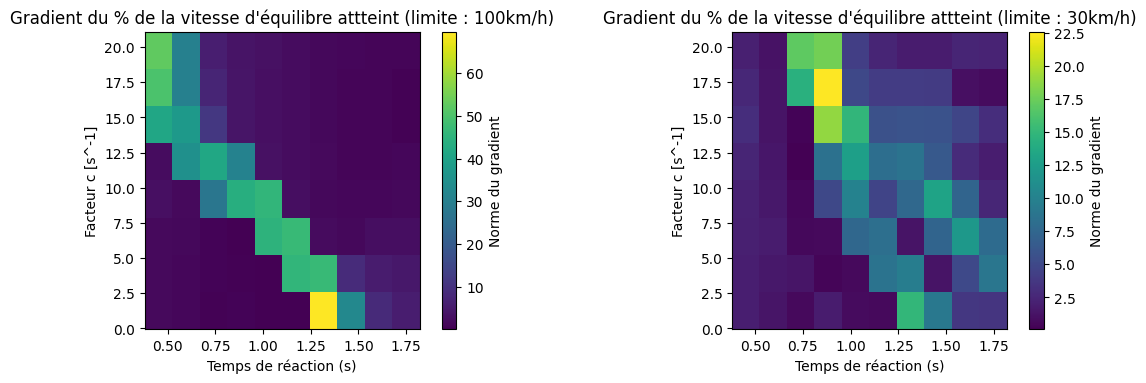

In [33]:
grad_meanSpeedcent = np.gradient(meanSpeedResult)
grad_meanSpeedtrente = np.gradient(meanSpeedResult2)

# Norme du gradient 
norme_meanSpeedcent = np.sqrt(grad_meanSpeedcent[0]**2 + grad_meanSpeedcent[1]**2)
norme_meanSpeedtrente = np.sqrt(grad_meanSpeedtrente[0]**2 + grad_meanSpeedtrente[1]**2)

# Affichage 
fig,ax = plt.subplots(nrows=1, ncols=2)

# Heatmap du gradient limite 100
img0 = ax[0].imshow(norme_meanSpeedcent, extent=extent, aspect=aspect)
plt.colorbar(img0, ax=ax[0], label="Norme du gradient")
ax[0].set_title("Gradient du % de la vitesse d'équilibre attteint (limite : 100km/h)")
ax[0].set_xlabel("Temps de réaction (s)")
ax[0].set_ylabel("Facteur c [s^-1]")

# Heatmap du gradient limite 30
img1 = ax[1].imshow(norme_meanSpeedtrente, extent=extent, aspect=aspect)
plt.colorbar(img1, ax=ax[1], label="Norme du gradient")
ax[1].set_title("Gradient du % de la vitesse d'équilibre attteint (limite : 30km/h)")
ax[1].set_xlabel("Temps de réaction (s)")
ax[1].set_ylabel("Facteur c [s^-1]")

fig.tight_layout(pad=0)
fig.set_figwidth(12)
fig.set_figheight(3)
plt.show()

## Limites des modèles présentés et prudence sur l'interprétation des résultats<a id='limits_id'></a>

Les modèles présentés dans ce rapport sont relativement simples et ne sont valides que sur certains régimes de fonctionnement. En particulier le premier modèle qui devient invalide après un crash. Or, ces modèles sont étudiés dans des conditions aux limites, quand la distance entre les voitures devient petite et que de grandes amplitudes de situation se présentent. Nos modèles n'étant pas garantis de fournir des valeurs utiles hors de leur domaine d'application, ces résultats prouvent uniquement l'émergence du phénomène, mais ne peuvent pas précisément en prédire l'ampleur. C'est pour cette raison que toutes les simulations qui servent aux heatmaps débutent à l'équilibre et évoluent à partir de ce cas. On veut rester au plus près des conditions de validité du modèle. Typiquement, il serait difficile d'étendre cette étude au cas du départ d'un péage.

La simulation est réalisée avec un petit nombre de voitures et sur un temps relativement cours : typiquement une vingtaine de voitures pendant quelques minutes. J'ai constaté que les résultats varient beaucoup si on ne considère que les 60 premières secondes. Il est très probable que pour certaines conditions, le système retournerait à l'équilibre après un temps suffisant de modélisation.

## Conclusion<a id='conclusion_id'></a>

A travers ce travail, nous avons pu étudier différentes approches de la modélisation du trafic routier simple (type autoroute). Après validation des modèles par l'expérience, nous avons pu explorer le comportement de ces modèles sur un espace de paramètre qui nous ont effectivement fourni une séparation de l'espace. Les paramètres comportementaux comme l'agressivité (les accélérations et freinages forts) et le temps de réaction sont très importants pour l'émergence des embouteillages. Typiquement, un grand nombre d'usagers assez peu réveillés tôt le matin (temps de réaction grand) et en retard pour leur travail (grandes accélérations et freinages) sont très propices aux embouteillages.

Dans son ensemble, nous avons pu retrouver les résultats intuitifs de l'apparition d'embouteillage par la modélisation numérique. Nous avons pu poser un cadre permettant de répondre aux questions concernant l'impact des différents paramètres sur l'apparition d'embouteillages qui restent stables. Nous avons aussi prouvé que quand les paramètres comportementaux sont suffisamment proches de la limite de stabilité, abaisser la limite de vitesse peut avoir un effet bénéfique sur la fluidité de la route. C'est une stratégie déjà adoptée par plusieurs grandes villes aux heures de pointe. Cet effet est très dépendant du temps de réaction des automobilistes et peut s'avérer très efficace si le temps de réaction des automobilistes est long. 

## Idées pour l'approfondissement du travail présenté<a id='advices_id'></a>

- Entrainer un modèle à partir de mesures sur autoroute
- Faire varier les paramètres accelMin, accelMax, breakMin, breakMax
- Étudier plus précisément la limite entre les 2 zones et quels effets abaissent la vitesse moyenne
- Faire varier la limite de vitesse dynamiquement pour éviter les bouchons
- Permettre aux voitures de se doubler